## Подготовка

Импортируем все необходимые библиотеки

In [2]:
#загружаем библиотеки для работы с данными
import pandas as pd
import numpy as np

#загружаем библиотеку для создания регулярных выражений
import re

#загружаем библиотеку для отображения времени выполнения ячейки и времени выполнения кода
import time

#загружаем библиотеку для корректной загрузки датасетов
import os

#загружаем библиотеку для проверки корректности url ссылки
import requests

#загружаем классы для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

#загружаем библиотеку для корреляционного анализа
import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функции для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#загружаем инструменты для подбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#загружаем библиотеку и класс для просчитывания важности признаков
from sklearn.inspection import permutation_importance
import shap

Объявляем также константы

In [3]:
RANDOM_STATE = 50525
TEST_SIZE = 0.25

## Загрузка и изучение данных

Загружаем файлы датасетов, создаем датафреймы, выводим первые 15 строк и основную информацию для ознакомления. Используем параметр `parse_dates` для того, чтобы сразу явно указать в `read_csv` столбец `BeginDate`, который необходимо преобразовать во временной тип данных, второй столбец `EndDate` имеет отличные от временного типа значения, поэтому его тип данных поменяем на временной позднее. Также сразу указываем параметр `index_col`, так как в первом столбце каждого датафрейма содержатся уникальные индексы клиентов.

In [4]:
#проверяем существование указанной дирректории и в случае возврата True загружаем датасеты в переменные, указав верные разделители
pth1 = '/datasets/contract_new.csv'
pth2 = 'https://.../contract_new.csv' #часть адреса скрыта ввиду NDA
pth3 = 'contract_new.csv'
if os.path.exists(pth1):
    df_contract = pd.read_csv(pth1, sep=',', decimal = '.', parse_dates = ['BeginDate'], index_col=[0])
    df_personal = pd.read_csv('/datasets/personal_new.csv', sep=',', decimal = '.', index_col=[0])
    df_internet = pd.read_csv('/datasets/internet_new.csv', sep=',', decimal = '.', index_col=[0])
    df_phone = pd.read_csv('/datasets/phone_new.csv', sep=',', decimal = '.', index_col=[0])
#добавляем проверку корректности url ссылки при помощи requests.get(url) и проверки status_code == 200
elif requests.get(pth2).status_code == 200:
    df_contract = pd.read_csv(pth2, sep=',', decimal = '.', parse_dates = ['BeginDate'], index_col=[0])
    df_personal = pd.read_csv('https://.../personal_new.csv', sep=',', decimal = '.', index_col=[0])  #часть адреса скрыта ввиду NDA
    df_internet = pd.read_csv('https://.../internet_new.csv', sep=',', decimal = '.', index_col=[0]) #часть адреса скрыта ввиду NDA
    df_phone = pd.read_csv('https://.../phone_new.csv', sep=',', decimal = '.', index_col=[0]) #часть адреса скрыта ввиду NDA
elif os.path.exists(pth3):
    df_contract = pd.read_csv(pth3, sep=',', decimal = '.', parse_dates = ['BeginDate'], index_col=[0])
    df_personal = pd.read_csv('personal_new.csv', sep=',', decimal = '.', index_col=[0])
    df_internet = pd.read_csv('internet_new.csv', sep=',', decimal = '.', index_col=[0])
    df_phone = pd.read_csv('phone_new.csv', sep=',', decimal = '.', index_col=[0])
else:
    print('Something is wrong')


#выводим первые 15 строк и основную информацию для каждого датафрейма    
for d in [df_contract,df_personal,df_internet, df_phone]:
    display(d.head(15))
    d.info()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


**Созданные датафреймы:**
- имеют разные размерности:
  - df_contract содержит 7043 объекта
  - df_personal содержит 7043 объекта
  - df_internet содержит 5517 объектов
  - df_phone содержит 6361 объект
- названия столбцов не приведены к змеиному "регистру"
- не имеет явных пропусков
- столбцы `EndDate` и `TotalCharges` имеют некорректные типы данных
- при первичном ознакомлении неявные дубликаты не выделяются

##  Предобработка данных

### Переименование столбцов

Для начала приведем названия столбцов к "змеиному" регистру: добавим при помощи регулярного выражения нижние подчеркивания в названиях столбцов перед всеми заглавными буквами, кроме начала строки, после этого приведем все буквы в наименованиях к нижнему регистру. Также сразу переименуем столбцы-индексы через `rename_axis`, присвоив им корректные наименования. Укажем параметр `inplace = True`, чтобы внести изменения именно в исходный датафрейм без присваивания значения переменной.

In [5]:
for d in [df_contract,df_personal,df_internet, df_phone]:
    d.columns = d.columns.str.replace('(?<!^)(?=[A-Z])', '_', regex = True).str.lower()
    d.rename_axis(index='customer_id', inplace = True)
    print(d.index.name)
    print(d.columns)

customer_id
Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')
customer_id
Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
customer_id
Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')
customer_id
Index(['multiple_lines'], dtype='object')


**В наименованиях столбцов добавлены нижние подчеркивания. Наименования столбцов приведены к змеиному регистру, лишних пробелов не обнаружено.**

### Обработка пропусков

Посчитаем все явные пропуски в датафрейме:

In [6]:
for d in [df_contract,df_personal,df_internet, df_phone]:
    print(d.isna().sum().sort_values(ascending = False))

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64
multiple_lines    0
dtype: int64


**Явных пропущенных значений в датафреймах не обнаружено**

### Аномальные значения

Выведем описательные статистики для всех столбцов. В локальном окружении установлена свежая версия библиотеки `pandas`, поэтому для корректного отображения статистик `datetime_is_numeric=True` не указываем. 

In [7]:
for d in [df_contract,df_personal,df_internet, df_phone]:
    try:
        #в новых версиях библиотеки datetime_is_numeric=True указывать не нужно
        display(round(d.describe(exclude='object').T,2))
        display(round(d.select_dtypes(include='object').describe().T,2))
    except:
        try:
            display(round(d.select_dtypes(include='object').describe().T,2))
        except:
            #в новых версиях библиотеки datetime_is_numeric=True указывать не нужно
            display(round(d.select_dtypes(exclude='object').describe().T,2))

,count,mean,min,25%,50%,75%,max,std
begin_date,7043,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
monthly_charges,7043.0,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047


,count,unique,top,freq
end_date,7043,67,No,5942
type,7043,3,Month-to-month,3875
paperless_billing,7043,2,Yes,4171
payment_method,7043,4,Electronic check,2365
total_charges,7043,6658,,11


,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.16,0.37,0.0,0.0,0.0,0.0,1.0


,count,unique,top,freq
gender,7043,2,Male,3555
partner,7043,2,No,3641
dependents,7043,2,No,4933


,count,unique,top,freq
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_t_v,5517,2,No,2810
streaming_movies,5517,2,No,2785


,count,unique,top,freq
multiple_lines,6361,2,No,3390


**Полученные статистики показывают следующее:**
- в столбце `end_date` 5942 строки не имеют дату окончания договора, значит это активные пользователи, из-за этого тип данных столбца некорректный. Чтобы в дальнейшем ввести новый признак - длительность договора, нам нужно вместо `No` указать дату взятия среза данных - `2020-02-01`
- в столбце `total_charges` 11 раз встречается неявный пропуск
- в столбце `begin_date` последняя дата начала договора не превышает значение среза данных
- в столбце с окончанием договора `end_date` всего 67 уникальных значений дат расторжения договоров

Взглянем еще раз на значения в столбце с датой окончания действия договора:

In [8]:
df_contract['end_date'].value_counts().head(10)

end_date
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
2019-10-01      31
2019-11-01      30
2019-03-01      28
2019-06-01      28
2018-09-01      28
Name: count, dtype: int64

До замены проверим, сколько строк уже имеет дату окончания договора `2020-02-01` 

In [9]:
df_contract[df_contract['end_date'] == '2020-02-01'].shape[0]

0

Таких строк еще нет, это нам поможет при генерации столбца с целевым признаком - спокойно для всех клиентов с датой '2020-02-01', на которую мы сейчас поменяем значение `No`, укажем класс 0 (договор активный), для всех остальных клиентов укажем значение 1 (договор прекращен). Укажем вместо `No` дату взятия среза данных - `2020-02-01`

In [10]:
df_contract.loc[df_contract['end_date'] == 'No','end_date'] = '2020-02-01'

Проверим замену

In [11]:
df_contract['end_date'].value_counts().head(10)

end_date
2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
2019-10-01      31
2019-11-01      30
2019-03-01      28
2019-06-01      28
2018-09-01      28
Name: count, dtype: int64

Теперь взглянем на строки с пропущенными значениями в столбце `total_charges`

In [12]:
df_contract.query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,


Значения в столбце `total_charges` отсутствуют по причине того, что договор на обслуживание заключен в день получения среза данных и поэтому эти клиенты еще не успели ни разу заплатить по договору. Можно произвести следующие действия в этом случае для обработки пропусков:
- удалить эти 11 объектов, так как клиентов всего 11 и длительность договора в 0 дней не покажет динамику пользования услугами и изменение ежемесячных платежей
- заполнить общие расходы значениями из ежемесячных платежей, так как даже при добавлении/удалении в первый месяц услуг стоимость ежемесячного платежа не сильно увеличится
- заполнение медианными значениями из других групп пользователей не подойдет ввиду остутсвия срока длительности договора

Взглянем на кол-во пользователей, у которых длительность договора составляет месяц и взглянем равны ли между собой столбцы с общими тратами и ежемесячными. Для того, чтобы не было предупреждений о несоответствии значения "2020-01-01" временному типу данных, то приведем эту дату к временному типу при помощи `@pd.Timestamp("2020-01-01")`

In [13]:
df_contract.query('begin_date == @pd.Timestamp("2020-01-01")').sample(15)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
8040-MNRTF,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,71.10,71.1
1156-ZFYDO,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.75,21.53
2080-SRCDE,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,25.40,25.4
2672-OJQZP,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,44.75,46.09
3069-SSVSN,2020-01-01,2020-02-01,One year,No,Mailed check,25.85,26.37
7439-DKZTW,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,80.55,80.55
2654-VBVPB,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),19.90,21.29
9244-ZVAPM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,45.60,45.6
1816-FLZDK,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,29.15,29.15


Как видно из полученной таблицы, у половины пользователей, которые уже имеют активный договор в течении месяца, ежемесячный платеж и общий уже не равны, поэтому заполнять общие расходы значениями из ежемесячных платежей не будем. Поэтому просто удалим эти 11 объектов.

In [14]:
df_contract = df_contract.query('total_charges != " "')

Проверяем кол-во оставшихся строк

In [15]:
df_contract.shape

(7032, 7)

Теперь еще раз проверим общие статистики в столбце с общими тратами. Типы данных в столбцах будем менять на корректные на следующем шаге, поэтому пока применим явное приведение к нужному типу значений в столце

In [16]:
round(df_contract['total_charges'].astype('float').describe().T,2)

count    7032.00
mean     2118.62
std      2112.74
min        19.05
25%       439.74
50%      1345.28
75%      3239.32
max      9221.38
Name: total_charges, dtype: float64

Проверим максимальное значение в этом столбце, не является ли оно аномалией. Для этого посмотрим на общее количество клиентов, которые потратили всего свыше 7000 за весь период

In [17]:
(df_contract['total_charges'].astype('float') > 7000).sum()

283

Таких клиентов оказалось не мало, поэтому все объекты с высокии общими тратами являются выбросами, но не аномалиями, поэтому они нужны для обучения модели на более высоких значениях столбца с общими тратами

С основными аномалиями в количественных и временных столбцах разобрались, категориальные столбцы будем более детально изучать при проверке данных на дубликаты.

**Во время обработки аномалий были выполены следующие основные действия:**
- проанализированы описательные статистики всех типов столбцов
- в столбце `end_date` у 5942 объектов, которые имеют действующий договор, значение `No` заменено на дату получения среза данных `2020-02-01`
- в столбце `total_charges` были удалены 11 объектов, у которых в этом столбце были неявные пропуски из-за того, что они в дату получения среза данных заключили договор и оплата еще не прошла

### Изменение типов данных столбцов

Проверим типы данных всех столбцов датафрейма:

In [18]:
for d in [df_contract,df_personal,df_internet, df_phone]:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 439.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner       

Поменяем тип данных у следующих столбцов:
- `end_date` на временной
- `total_charges` на численный с плавающей точкой

Для удобства типы данных поменяем через словарь

In [19]:
df_contract = df_contract.astype({
    'total_charges': 'float',
    'end_date': 'datetime64[ns]'
})

Проверим получившийся результат

In [20]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 439.5+ KB


**На этапе изменения типов данных в столбцах было сделано следующее:**
- тип данных столбца `end_date` изменен на `datetime64[ns]`
- тип данных столбца `total_charges` изменен на `float`

Перед проверкой на дубликаты необходимо объединить датафреймы в один общий, тогда будет понятно, сколько уникальных объектов имеется

### Объединение датафреймов

Так как в датайрейме `df_contract` мы удалили несколько объектов, то за основной датафрейм возьмем его и последовательно будем присоединять остальные датафреймы при помощи `merge`.

Сначала к `df_contract` присоединим датафрейм с информацией о клиентах `df_personal` по столбцам-индексам, указывая их через параметры `left_index=True` и `right_index=True`. Укажем тип объединения `inner`, чтобы заодно проверить соответствуют ли все клиенты из этих двух датафреймов друг другу

In [21]:
df_all = pd.merge(df_contract, df_personal, how = 'inner', left_index=True, right_index=True)
display(df_all.sample(15))
print(df_all.info())

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents
customer_id,,,,,,,,,,,
5274-XHAKY,2016-09-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),94.30,4136.94,Female,0,Yes,Yes
1852-QSWCD,2014-10-01,2020-02-01,Two year,Yes,Mailed check,24.80,1587.20,Male,0,Yes,Yes
5288-AHOUP,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,78.50,898.04,Male,1,No,No
3014-WJKSM,2017-09-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),75.30,2205.54,Male,0,Yes,No
4619-EVPHY,2018-06-01,2020-02-01,One year,Yes,Bank transfer (automatic),91.00,1820.00,Female,1,Yes,No
0932-YIXYU,2016-03-01,2020-02-01,Two year,No,Credit card (automatic),20.25,980.30,Female,0,No,No
1293-HHSHJ,2017-03-01,2020-02-01,One year,No,Mailed check,21.10,797.58,Female,0,No,No
7354-OIJLX,2019-05-01,2020-02-01,Month-to-month,Yes,Electronic check,75.85,682.65,Male,0,No,No
9135-HSWOC,2014-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),19.70,1260.80,Male,0,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   int64         
 9   partner            7032 non-null   object        
 10  dependents         7032 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 659.2+ KB
None


Объединение произведено корректно, всем `id` клиентов из первой таблицы нашлись соответстсвующие `id` из второй таблицы. Теперь присоединим датафрейм с информацией об интернет-услугах и телефонии сразу. Теперь в типе объединения укажем `left`, так как не все клиенты имеют интернет и телефонию, а потом заполним пропущенные значения заглушками. Воспользуемся теперь методом `join` для объединения по индексам.

In [22]:
df_all = df_all.join(df_internet, how='left').join(df_phone, how='left')
display(df_all.sample(20))
print(df_all.info())

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
6726-WEXXK,2017-11-01,2020-02-01,One year,Yes,Electronic check,85.90,2365.69,Male,1,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,Yes
5468-BPMMO,2016-04-01,2020-02-01,Month-to-month,No,Electronic check,19.60,901.60,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1678-FYZOW,2019-07-01,2019-10-01,Month-to-month,Yes,Electronic check,79.40,250.11,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,No
0023-HGHWL,2019-10-01,2020-02-01,Month-to-month,Yes,Electronic check,25.10,100.40,Male,1,No,No,DSL,No,No,No,No,No,No,NaN
9788-HNGUT,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),116.95,8673.01,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5027-QPKTE,2019-06-01,2020-02-01,Month-to-month,Yes,Electronic check,69.35,554.80,Male,0,Yes,No,Fiber optic,No,No,No,No,No,No,No
3090-QFUVD,2020-01-01,2020-02-01,Month-to-month,No,Credit card (automatic),20.30,20.30,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9209-NWPGU,2016-06-01,2019-12-01,One year,No,Electronic check,65.40,2966.54,Male,0,No,No,DSL,Yes,No,No,Yes,Yes,No,No
7252-NTGSS,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,45.15,45.60,Female,0,No,No,DSL,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   int64         
 9   partner            7032 non-null   object        
 10  dependents         7032 non-null   object        
 11  internet_service   5512 non-null   object        
 12  online_security    5512 non-null   object        
 13  online_backup      5512 non-null   object        
 14

Видно, что в датафрейме `df_internet` не нашлось 5 строк с необходимыми индексами клиентов, а в `df_phone` не нашлось 9 соответствующих индексов клиентов, поэтому эти строки при объединении в общий датафрейм не попали.

Следующим шагом необходимо все образовавшиеся пропущенные значения после присоединения данных об интернет-услугах и телефонии заполнить заглушками. Так как это все категориальные столбцы, то в качестве заглушки используем значение `unknown`.

In [23]:
df_all[df_internet.columns.tolist() + df_phone.columns.tolist()] =\
df_all[df_internet.columns.tolist() + df_phone.columns.tolist()].fillna(value='unknown')

Проверим произведенную замену

In [24]:
df_all.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
8380-MQINP,2015-07-01,2020-02-01,Two year,No,Mailed check,20.30,1116.50,Female,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
2452-MRMZF,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),25.70,1887.41,Female,1,Yes,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Yes
1093-YSWCA,2019-03-01,2020-02-01,Two year,No,Credit card (automatic),19.55,234.40,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
7113-HIPFI,2014-08-01,2020-02-01,Two year,No,Mailed check,65.85,4780.71,Male,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No,No
9168-INPSZ,2016-06-01,2020-02-01,Month-to-month,No,Electronic check,104.15,4582.60,Female,1,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
1334-PDUKM,2014-06-01,2020-02-01,One year,No,Credit card (automatic),86.45,5878.60,Female,0,Yes,No,Fiber optic,No,Yes,Yes,No,No,No,Yes
3763-GCZHZ,2014-07-01,2015-11-01,One year,Yes,Electronic check,104.05,1781.34,Male,0,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Yes
5820-PTRYM,2015-06-01,2020-02-01,One year,Yes,Credit card (automatic),68.45,3833.20,Female,1,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Yes
1394-SUIUH,2016-06-01,2018-03-01,Month-to-month,Yes,Electronic check,85.15,1806.03,Female,1,Yes,No,Fiber optic,Yes,Yes,No,Yes,No,No,No


Замена произведена корректно

**На этапе последовательного объединения датафреймов в один общий  было получено следующее:**
- все датафреймы последовательно соединены друг с другом при помощи `merge` и `join` по столбцам-индексам.
- при объединении в датафрейме df_internet не нашлось 5 строк с необходимыми индексами клиентов, а в df_phone не нашлось 9 соответствующих индексов клиентов, поэтому эти строки при объединении в общий датафрейм не попали.
- образовавшиеся пропущенные значения в столбцах с информацией об интернет-услугах и телефонии были заменены на значения-заглушки `unknown`.

### Обработка дубликатов

Проверим объединенный датафрейм на наличие явных дубликатов:

In [25]:
df_all.duplicated().sum()

4

Удалим эти явные дубликаты из датафрейма, обновлять индексы не стоит, так как столбец-индекс не просто порядковый номер строки

In [26]:
print(f'Количество строк до удаления {df_all.shape[0]}')
df_all = df_all.drop_duplicates()
print(f'Количество строк после удаления {df_all.shape[0]}')

Количество строк до удаления 7032
Количество строк после удаления 7028


Теперь проверим наличие неявных дубликатов

In [27]:
for c in df_all.select_dtypes(include='object').columns.tolist():
    print(f'Значение столбца {c}: {df_all[c].unique()}')

Значение столбца type: ['Month-to-month' 'One year' 'Two year']
Значение столбца paperless_billing: ['Yes' 'No']
Значение столбца payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Значение столбца gender: ['Female' 'Male']
Значение столбца partner: ['Yes' 'No']
Значение столбца dependents: ['No' 'Yes']
Значение столбца internet_service: ['DSL' 'Fiber optic' 'unknown']
Значение столбца online_security: ['No' 'Yes' 'unknown']
Значение столбца online_backup: ['Yes' 'No' 'unknown']
Значение столбца device_protection: ['No' 'Yes' 'unknown']
Значение столбца tech_support: ['No' 'Yes' 'unknown']
Значение столбца streaming_t_v: ['No' 'Yes' 'unknown']
Значение столбца streaming_movies: ['No' 'Yes' 'unknown']
Значение столбца multiple_lines: ['unknown' 'No' 'Yes']


Неявных дубликатов не обнаружено.

**На этапе обработки дубликатов были проделаны следующие действия:**
- удалено 4 явных дубликаты в объединенном датафрейме
- проверено наличие неявных дубликатов

### Добавление новых признаков

Попробуем добавить в датасет несколько новых признаков:
- так как у нас отсутствует столбец с целевым признаком, то сгенерируем его на основе столбца `end_date`. Помним, что до того, как мы указали дату получения среза данных `2020-02-01`, у всех этих объектов стояло значение `No` в столбце `end_date`, поэтому мы можем для всех этих клиентов поменять значение даты среза на 0 (договор активный), а всем остальным клиентам, у которых уже была дата окончания договора, проставить значение 1 (договор прекращен).
- новый входной признак, показывающий длительность договора, выраженную в количестве дней, для этого вычтем из столбца `end_date` столбец `begin_date`. Для некоторых пользователей, которые только недавно заключили договор и не собираются пока уходить, время пользования будет искажено, конечно, но зато это может помочь модели увидеть зависимости для большинства пользователей, которые долго пользуются услугами этого провайдера
- новый входной признак, показывающий количество подключенных интернет услуг у пользователя, для этого сложим все столбцы с интернет-услугами
- новый бинарный входной признак, показывающий менял ли клиент тариф или подключал/отключал услуги. Для этого разделим общую затраченную сумму на количество месяцев пользования договора и если полученное число совпадет со значением в столбце ежемесячная плата, то клиент не менял тариф или договор (`No` - не менял тариф и не подключал услуги, `Yes` - менял тариф или подключал услуги) 

Сначала добавим целевой признак `terminated` в датасет. Для всех клиентов с датой `2020-02-01` укажем класс 0 (договор активный), а всем остальным клиентам проставим значение 1 (договор заверщен).

In [28]:
#создаем столбец на основе столбца `end_date`
df_all['terminated'] = np.where(df_all['end_date'] == '2020-02-01', 0, 1)

Проверяем добавленный столбец

In [29]:
#снимем ограничение по количествую отображаемых строк и столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_all.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,terminated
customer_id,,,,,,,,,,,,,,,,,,,,
7621-VPNET,2016-08-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),85.90,3752.11,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Yes,0
4603-JANFB,2019-10-01,2020-02-01,Month-to-month,Yes,Electronic check,69.85,279.40,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
7607-QKKTJ,2016-05-01,2016-06-01,One year,Yes,Credit card (automatic),95.00,103.55,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Yes,1
7029-RPUAV,2018-05-01,2018-07-01,Month-to-month,Yes,Credit card (automatic),100.45,200.90,Male,1,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1
2207-QPJED,2017-01-01,2020-02-01,Month-to-month,No,Electronic check,90.00,3463.20,Female,1,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,No,No,0
4111-BNXIF,2014-07-01,2020-02-01,Two year,Yes,Electronic check,59.55,3989.85,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,unknown,0
7614-QVWQL,2015-09-01,2016-07-01,One year,Yes,Bank transfer (automatic),51.80,518.00,Male,0,Yes,Yes,DSL,No,Yes,No,No,Yes,Yes,unknown,1
3556-BVQGL,2018-06-01,2020-02-01,One year,Yes,Mailed check,20.00,400.00,Female,0,Yes,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0
0939-YAPAF,2016-12-01,2020-01-01,Month-to-month,Yes,Electronic check,100.25,3709.25,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1


Целевой признак добавлен корректно

Сразу посмотрим на баланс классов в целевом признаке

In [30]:
df_all['terminated'].value_counts()

terminated
0    5927
1    1101
Name: count, dtype: int64

*Виден явный дисбаланс классов. Клиентов, расторгнувших договор, 18.5% от общего числа.*

Теперь добавим столбец с длительностью договора

In [31]:
df_all['duration'] = (df_all['end_date'] - df_all['begin_date']).dt.days

Также проверим получившийся новый столбец

In [32]:
df_all.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,terminated,duration
customer_id,,,,,,,,,,,,,,,,,,,,,
8413-VONUO,2019-08-01,2020-02-01,Month-to-month,No,Electronic check,95.65,585.38,Male,0,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,No,0,184
7216-KAOID,2016-09-01,2020-02-01,One year,No,Bank transfer (automatic),19.50,799.50,Male,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,1248
8401-EMUWF,2016-08-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),69.40,3177.13,Male,0,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Yes,0,1279
0584-BJQGZ,2018-01-01,2019-12-01,Month-to-month,Yes,Bank transfer (automatic),78.35,1802.05,Female,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,1,699
8510-BBWMU,2016-09-01,2020-02-01,One year,Yes,Mailed check,19.75,809.75,Female,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,1248
5756-JYOJT,2019-03-01,2020-02-01,One year,No,Credit card (automatic),64.90,771.01,Female,0,No,No,DSL,No,No,Yes,Yes,No,Yes,No,0,337
8098-TDCBU,2016-08-01,2020-02-01,Two year,No,Electronic check,25.25,1166.55,Female,0,Yes,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Yes,0,1279
1298-PHBTI,2014-03-01,2020-02-01,Two year,Yes,Electronic check,84.80,6020.80,Male,0,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,No,Yes,0,2163
1814-DKOLC,2019-09-01,2020-02-01,Month-to-month,No,Mailed check,25.45,127.25,Female,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Yes,0,153


Столбец с длительностью договора добавлен корректно

Теперь добавим столбец с кол-вом подключенных интернет услуг. Для этого суммируем все интернет-услуги клиента и вынесем в отдельный столбец `count_services` эту цифру.

In [33]:
#составляем таблицу из True-False для всех столбцов с интернет-услугами, а потом суммируем значения в каждой строке
df_all['count_services'] = (df_all[df_internet.columns.tolist()] == 'Yes').sum(axis=1)

Для всех тех клиентов, у которых нет подключенного интернета (все значения в столбцах с интернет-услугами равны `unknown`), для корректности изменим значение 0 на значение-заглушку -1, так как они другая категория клиентов, чем те, которые просто не пользуются интернет-услугами, но имеют интернет

In [34]:
df_all['count_services'] = df_all['count_services'].where(df_all['internet_service'] != 'unknown', -1)

Проверяем добавленный столбец с количеством интернет-услуг

In [35]:
df_all.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,terminated,duration,count_services
customer_id,,,,,,,,,,,,,,,,,,,,,,
4745-LSPLO,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,20.50,61.50,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,92,-1
9518-XXBXE,2019-04-01,2020-02-01,Month-to-month,No,Electronic check,75.30,820.77,Male,1,Yes,No,Fiber optic,Yes,No,No,No,No,No,No,0,306,1
3594-IVHJZ,2019-12-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,44.99,Female,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,62,-1
4104-PVRPS,2018-02-01,2020-02-01,Month-to-month,No,Mailed check,53.60,1286.40,Male,0,Yes,No,DSL,Yes,No,No,Yes,No,No,No,0,730,2
1821-BUCWY,2017-08-01,2020-02-01,Two year,Yes,Mailed check,55.65,1669.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,914,2
5639-NTUPK,2019-01-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),52.10,704.39,Male,0,No,Yes,DSL,Yes,No,No,No,No,No,No,0,396,1
9375-MHRRS,2019-08-01,2020-02-01,Month-to-month,No,Mailed check,50.05,303.30,Male,0,No,No,DSL,No,No,No,Yes,No,No,No,0,184,1
4578-PHJYZ,2015-10-01,2020-02-01,One year,Yes,Electronic check,68.75,3575.00,Male,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,No,0,1584,4
6776-TLWOI,2019-07-01,2019-12-01,Month-to-month,No,Mailed check,19.85,99.25,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,1,153,-1


Значения присвоены корректно

Добавим последний столбец с новым входным бинарным признаком - менял или подключал какие-либо услуги клиент или нет со значениями `Yes` (менял тариф/подключал услуги) или `No` (ничего не подключал/тариф не менял). Сделаем это следующим образом:
- возьмем длительность действия договора (разницу между столбцами `end_date` и `begin_date`)
- разделим эту разницу на временной интервал в 30 дней (`np.timedelta64(30, 'D')`)
- округлим до целого числа, отбросив числа после  запятой, чтобы месяц получился целым числом. Отбрасывание дробной части не искажает корректное итоговое количество месяцев.
- разделим итоговую затраченную сумму денег за все время `total_charges` на получившееся кол-во месяцев и узнаем сколько в среднем тратит клиент за месяц, округлим эту цифру до 2 знаков, так как столбец `monthly_charges` имеет 2 знака после запятой и для корректного сравнения нужно уравнять эти значения до одного кол-ва знаков после запятой.
- создадим новый бинарный признак `changed_service`, сравнив значение в `monthly_charges` и наше расчитанное значение средних трат по месяцам за все время:
   - присвоим `No` такому объекту, если значения совпадут, значит, услуги не добавлял/тариф не менял
   - присвоим `Yes` если не совпадут значения, значит, менял тариф/подключал услуги

In [36]:
df_all['changed_service'] = np.where(
        df_all['monthly_charges'] == \
        round(df_all['total_charges'] / round((df_all['end_date'] - df_all['begin_date'])/ np.timedelta64(30, 'D')),2),
                                    'No','Yes'
                                    )

Проверим корректность нового столбца

In [37]:
df_all.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,terminated,duration,count_services,changed_service
customer_id,,,,,,,,,,,,,,,,,,,,,,,
7706-DZNKK,2019-03-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),20.45,224.95,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,337,-1,No
2673-CXQEU,2015-06-01,2020-02-01,One year,No,Electronic check,110.50,6435.52,Female,1,No,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Yes,0,1706,5,Yes
9708-KFDBY,2020-01-01,2020-02-01,Month-to-month,No,Credit card (automatic),20.55,20.55,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,31,-1,No
9081-WWXKP,2016-03-01,2018-08-01,Two year,No,Credit card (automatic),20.25,640.10,Female,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,1,883,-1,Yes
0107-WESLM,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,19.85,100.24,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,153,-1,Yes
9135-HSWOC,2014-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),19.70,1260.80,Male,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,1949,-1,Yes
8410-BGQXN,2019-10-01,2020-02-01,Month-to-month,No,Mailed check,19.40,77.60,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0,123,-1,No
4939-KYYPY,2017-11-01,2020-02-01,Month-to-month,No,Electronic check,59.45,1733.56,Male,0,No,No,DSL,No,No,Yes,Yes,No,No,Yes,0,822,2,Yes
5351-QESIO,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,24.20,24.20,Male,0,No,Yes,DSL,No,No,No,No,No,No,unknown,0,31,0,No


Значения в новом бинарном признаке добавлены корректно

Проверим теперь корректность типов для всех добавленных столбцов

In [38]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7028 non-null   datetime64[ns]
 1   end_date           7028 non-null   datetime64[ns]
 2   type               7028 non-null   object        
 3   paperless_billing  7028 non-null   object        
 4   payment_method     7028 non-null   object        
 5   monthly_charges    7028 non-null   float64       
 6   total_charges      7028 non-null   float64       
 7   gender             7028 non-null   object        
 8   senior_citizen     7028 non-null   int64         
 9   partner            7028 non-null   object        
 10  dependents         7028 non-null   object        
 11  internet_service   7028 non-null   object        
 12  online_security    7028 non-null   object        
 13  online_backup      7028 non-null   object        
 14

Для корректного отображения на графиках по оси `x` значений целевого признака изменим тип данных столбца `terminated` на `int64`

In [39]:
df_all['terminated'] = df_all['terminated'].astype('int64')

Еще раз проверим типы данных столбцов в объединенном датафрейме

In [40]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7028 non-null   datetime64[ns]
 1   end_date           7028 non-null   datetime64[ns]
 2   type               7028 non-null   object        
 3   paperless_billing  7028 non-null   object        
 4   payment_method     7028 non-null   object        
 5   monthly_charges    7028 non-null   float64       
 6   total_charges      7028 non-null   float64       
 7   gender             7028 non-null   object        
 8   senior_citizen     7028 non-null   int64         
 9   partner            7028 non-null   object        
 10  dependents         7028 non-null   object        
 11  internet_service   7028 non-null   object        
 12  online_security    7028 non-null   object        
 13  online_backup      7028 non-null   object        
 14

Теперь все новые столбцы имеют корректные типы данных

**На этапе добавления новых признаков в датасет были добавлены новые столбцы:**
-  целевой признак `terminated`. Для всех клиентов с датой `2020-02-01` указан класс 0 (договор активный), а всем остальным клиентам просвоено значение 1 (договор заверщен).
- входной признак `duration`, отображающий длительность договора в днях
- входной признак `count_services`, отображающий кол-во подключенных интернет-услуг. Для клиентов, у которых нет интернета, проставлено значение-заглушка `-1`
- входной бинарный признак `changed_service`, показывающий менял или подключал какие-либо услуги клиент или нет со значениями:
  - `Yes` -  если менял тариф/подключал услуги
  - `No` - если услуги не добавлял/тариф не менял

**На этапе предобработки данных были получены следующие результаты:**
- в наименованиях столбцов добавлены нижние подчеркивания. Наименования столбцов приведены к змеиному регистру, проведена проверка на лишние знаки и пробелы.
- явных пропущенных значений в датафреймах не обнаружено
- проанализированы описательные статистики всех типов столбцов
- в столбце `end_date` у 5942 объектов, которые имеют действующий договор, значение `No` заменено на дату получения среза данных `2020-02-01`
- в столбце `total_charges` были удалены 11 объектов, у которых в этом столбце были неявные пропуски из-за того, что они в дату получения среза данных заключили договор и оплата еще не прошла
- тип данных столбца `end_date` изменен на `datetime64[ns]`
- тип данных столбца `total_charges` изменен на `float`
- все датафреймы последовательно соединены друг с другом при помощи `merge` и `join` по столбцам-индексам.
- при объединении в датафрейме `df_internet` не нашлось 5 строк с необходимыми индексами клиентов, а в `df_phone` не нашлось 9 соответствующих индексов клиентов, поэтому эти строки при объединении в общий датафрейм не попали.
- образовавшиеся пропущенные значения в столбцах с информацией об интернет-услугах и телефонии были заменены на значения-заглушки `unknown`.
- удалено 4 явных дубликаты в объединенном датафрейме
- проверено наличие неявных дубликатов
- были добавлены новые столбцы в объединенный датафрейм:
  -  целевой признак `terminated`. Для всех клиентов с датой `2020-02-01` указан класс 0 (договор активный), а всем остальным клиентам просвоено значение 1 (договор завершен). Наблюдается дисбаланс классов. Клиентов, расторгнувших договор, 18.5% от общего числа.
  - входной признак `duration`, отображающий длительность договора в днях
  - входной признак `count_services`, отображающий кол-во подключенных интернет-услуг. Для клиентов, у которых нет интернета, проставлено значение-заглушка `-1`
  - входной бинарный признак `changed_service`, показывающий менял или подключал какие-либо услуги клиент или нет, со значениями:
    - `Yes` - если менял тариф/подключал услуги
    - `No` - если услуги не добавлял/тариф не менял

## Исследовательский анализ

Выведем снова все описательные статистики теперь уже для объединенного датафрейма. В локальном окружении установлена свежая версия библиотеки `pandas`, поэтому для корректного отображения статистик `datetime_is_numeric=True` не указываем. 

In [41]:
try:
    #в новых версиях библиотеки datetime_is_numeric=True указывать не нужно 
    display(round(df_all.describe(exclude='object').T,2)) 
    display(round(df_all.select_dtypes(include='object').describe().T,2))
except:
    try:
        display(round(df_all.select_dtypes(include='object').describe().T,2))
    except:
        #в новых версиях библиотеки datetime_is_numeric=True указывать не нужно
        display(round(df_all.select_dtypes(exclude='object').describe().T,2))

,count,mean,min,25%,50%,75%,max,std
begin_date,7028,2017-04-29 00:39:08.093340928,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-01-01 00:00:00,NaN
end_date,7028,2019-10-15 20:50:28.343767808,2014-06-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN
monthly_charges,7028.0,64.809555,18.25,35.65,70.35,89.8625,118.75,30.075631
total_charges,7028.0,2118.39332,19.05,439.9875,1345.275,3239.3175,9221.38,2111.787509
senior_citizen,7028.0,0.162493,0.0,0.0,0.0,0.0,1.0,0.368929
terminated,7028.0,0.156659,0.0,0.0,0.0,0.0,1.0,0.363505
duration,7028.0,899.841207,28.0,276.0,761.0,1461.0,2314.0,682.428205
count_services,7028.0,1.822567,-1.0,0.0,2.0,3.0,6.0,2.111714


,count,unique,top,freq
type,7028,3,Month-to-month,3873
paperless_billing,7028,2,Yes,4167
payment_method,7028,4,Electronic check,2365
gender,7028,2,Male,3546
partner,7028,2,No,3637
dependents,7028,2,No,4930
internet_service,7028,3,Fiber optic,3095
online_security,7028,3,No,3497
online_backup,7028,3,No,3087
device_protection,7028,3,No,3094


**Полученные статистики показывают следующее:**

- из даты заключения и окончания договоров видно, что предоставлены данные за период с октября 2013 года по февраль 2020
- медианное значение среднемесячных платежей за тариф и услуги составляет 70.35, а общих платежей за все время - 1345.275
- пенсионеров в наших данных около 19.4% от общего числа
- клиентов, прекративших договор, окло 18.5% от общего числа, явных дисбаланс классов, нужно будет применить стратификацию и балансировку весов в моделях
- медианное значение длительности договора составляет 2 года у данного оператора
- медианное значение подключенных интернет-услуг у пользователей - 2
- клиенты чаще меняют тариф или подключают услуги, чем ничего не меняют за все время действия договора
- если рассматривать каждую интернет-услугу, то люди чаще не пользуются ими, чем подключают
- чаще всего люди выбирают ежемесячный способ оплаты
- наибольшая часть клиентов не имеет детей и не женаты
- мужчин и женщин практически поровну среди клиентов

Построим поочередно графики для всех признаков. Сначала построим графики распределения всех количественных признаков объединенного датафрейма с разными типами графиков для дискретных и непрерывных величин. Для лучшей визуалиазации и понимания количества оставшихся/ушедших клиентов в завимости от разных признаков добавим рядом дублирующий график, но только с разделением клиентов по группам

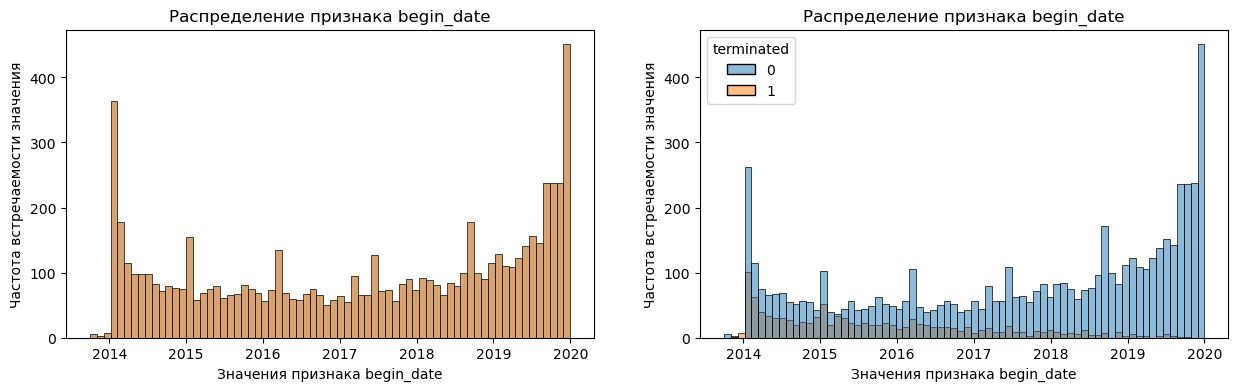

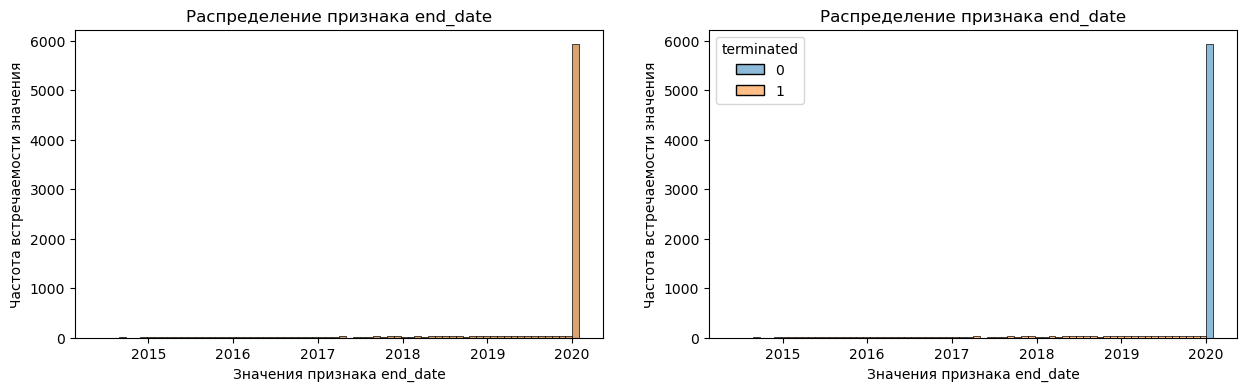

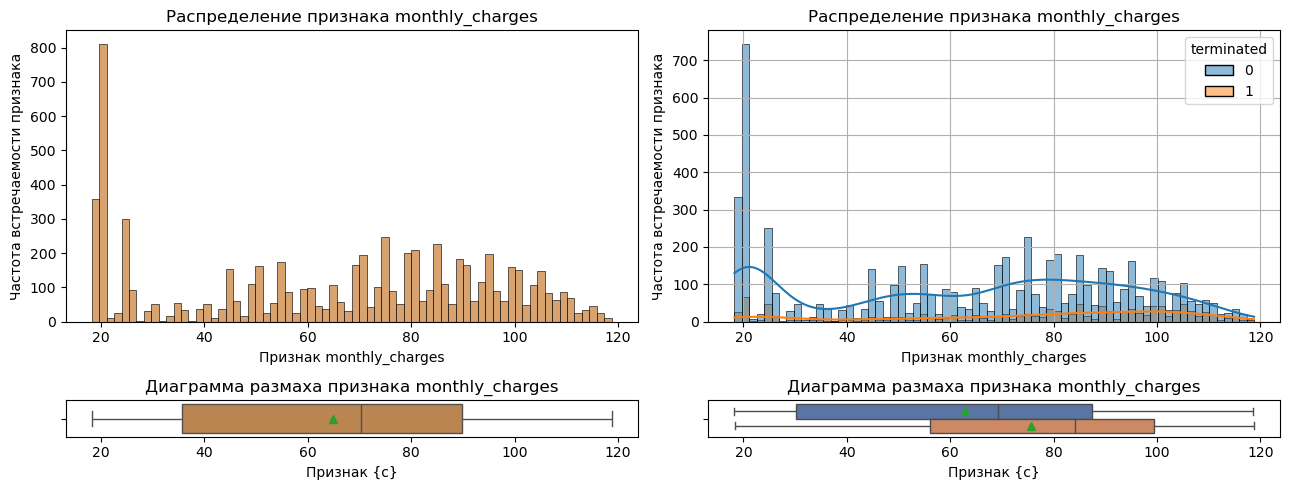

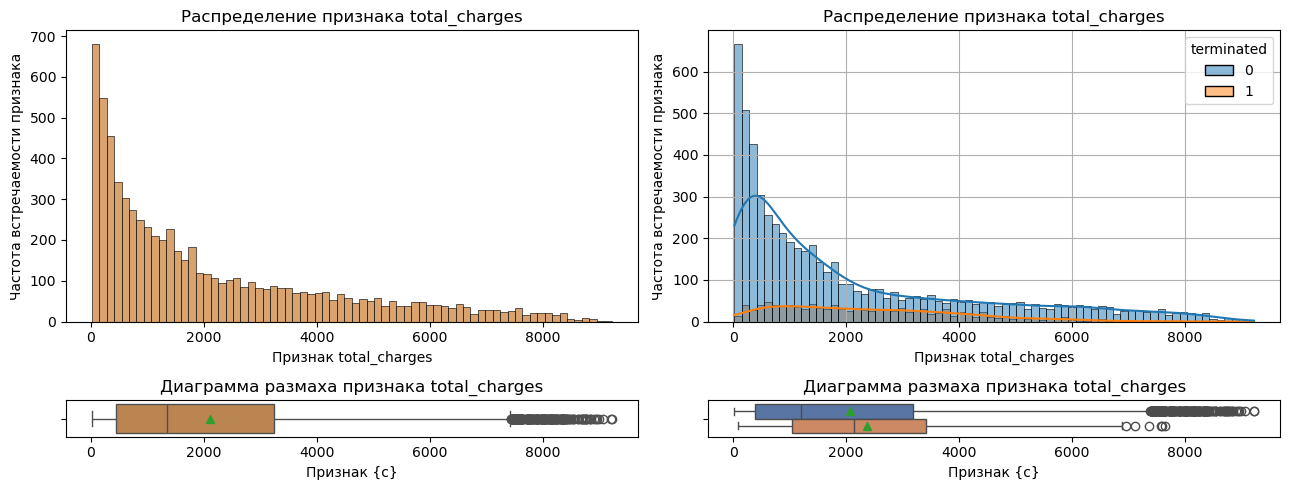

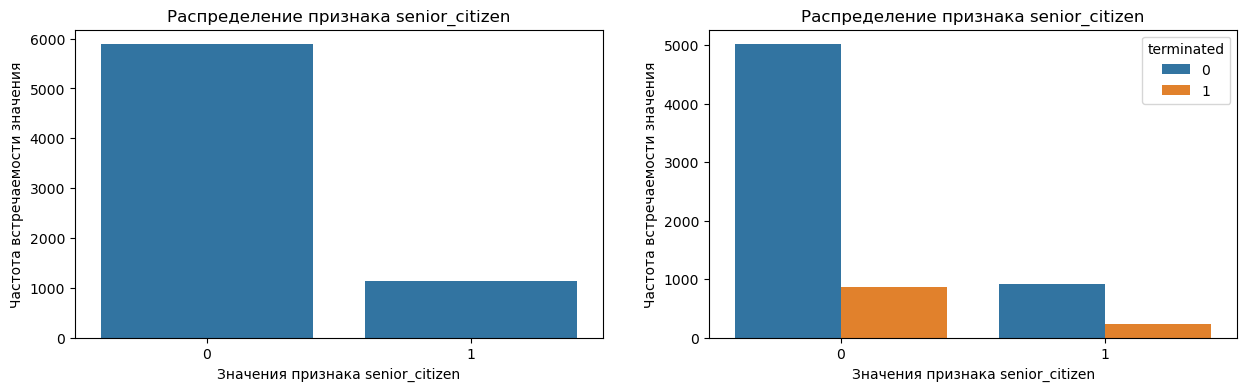

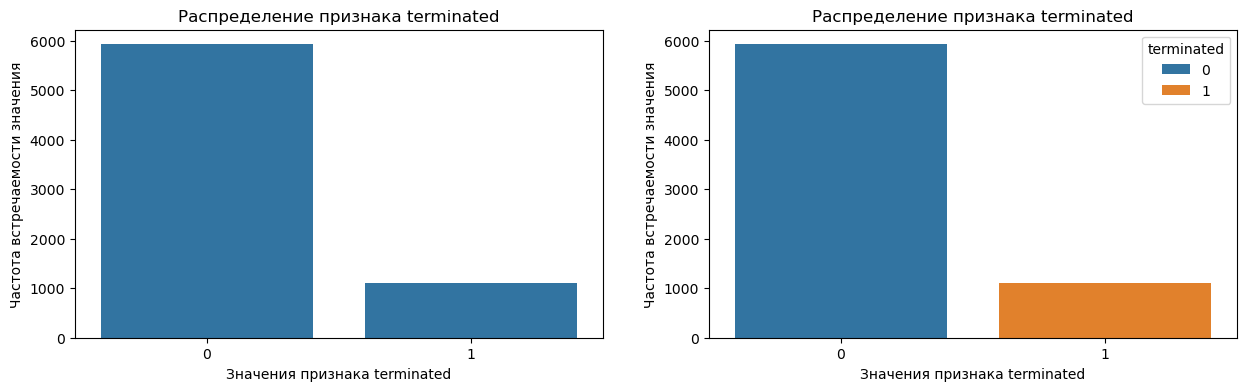

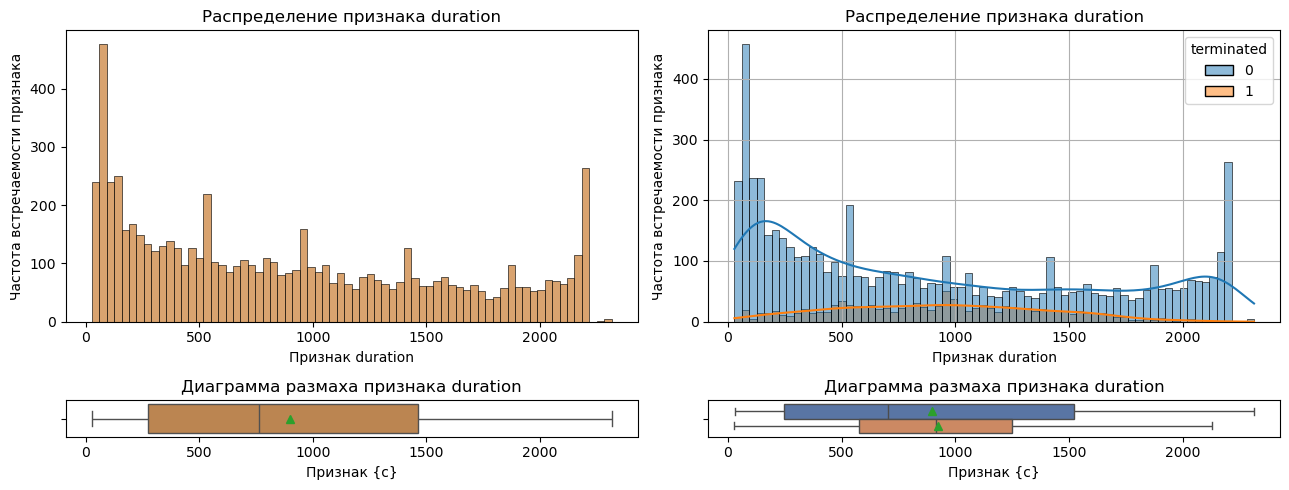

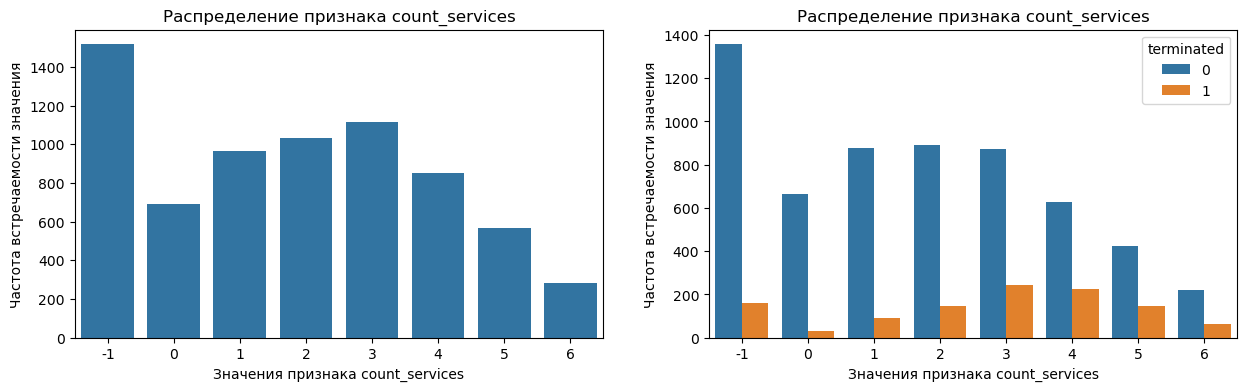

In [42]:
for c in df_all.select_dtypes(exclude='object').columns.tolist(): 
    
#условие для построения графиков для дискретных значений (целочисленные и меньше 30 в наборе уникальных значений) 
        if (df_all[c].dtype == 'int64') and (len(df_all[c].unique()) < 30):
            #создаем сразу две фигуры в линию и оси к ней, подписываем оси и наименование графиков
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
            axes[0].set_title(f'Распределение признака {c}')
            axes[0].set_xlabel(f'Значения признака {c}')
            axes[0].set_ylabel('Частота встречаемости значения')
        
            axes[1].set_title(f'Распределение признака {c}')
            axes[1].set_xlabel(f'Значения признака {c}')
            axes[1].set_ylabel('Частота встречаемости значения')
            
            sns.countplot(data = df_all, x=c,ax=axes[0])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[0].set_xlabel(f'Значения признака {c}')
            axes[0].set_ylabel('Частота встречаемости значения')
            
            sns.countplot(data = df_all, x=c, hue = 'terminated', ax=axes[1])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[1].set_xlabel(f'Значения признака {c}')
            axes[1].set_ylabel('Частота встречаемости значения')
            plt.show()

        elif df_all[c].dtype == 'datetime64[ns]':
            #график для столбцов с временным типом данных 
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
            axes[0].set_title(f'Распределение признака {c}')
            axes[0].set_xlabel(f'Значения признака {c}')
            axes[0].set_ylabel('Частота встречаемости значения')
        
            axes[1].set_title(f'Распределение признака {c}')
            axes[1].set_xlabel(f'Значения признака {c}')
            axes[1].set_ylabel('Частота встречаемости значения')
            
            sns.histplot(data = df_all, x = c, color = 'peru', bins = 70, ax=axes[0])
            sns.histplot(data = df_all, x = c, color = 'peru', bins = 70, ax=axes[1], hue = 'terminated')
        else:
            #оставшиеся значения (с плавающей точкой или целочисленные, но в наборе больше 30 значений)
            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,5), gridspec_kw={'height_ratios': [12, 1.5]})
            sns.histplot(data = df_all, x=c, color = 'peru', bins = 70, legend = True, ax=axes[0][0])
            axes[0][0].set_title(f'Распределение признака {c}')
            axes[0][0].set_xlabel(f'Признак {c}')
            axes[0][0].set_ylabel('Частота встречаемости признака')

            sns.boxplot(data = df_all, x=c, color='peru', showmeans = True, ax=axes[1][0])        
            axes[1][0].set_title(f'Диаграмма размаха признака {c}')
            axes[1][0].set_xlabel('Признак {c}')
            axes[1][0].set_ylabel('')

            sns.histplot(data = df_all, x=c, color = 'peru', bins = 70, legend = True, ax=axes[0][1], hue = 'terminated', kde=True)
            axes[0][1].set_title(f'Распределение признака {c}')
            axes[0][1].set_xlabel(f'Признак {c}')
            axes[0][1].set_ylabel('Частота встречаемости признака')
            axes[0][1].grid(True)

            #в более свежей версии seaborn нужно указывать параметры palette = 'deep', legend=False
            sns.boxplot(data = df_all, x=c, hue = 'terminated', showmeans = True, palette = 'deep', legend=False, ax=axes[1][1])        
            axes[1][1].set_title(f'Диаграмма размаха признака {c}')
            axes[1][1].set_xlabel('Признак {c}')
            axes[1][1].set_ylabel('')

            #настраиваем динамическое отображения графиков
            plt.tight_layout()
            plt.show()

**Графики показывают следующее:**
- всплески новых пользователей были в начале 2014 года и в конце 2020 года. График показывает, что до 2016 года доля ушедших от общего количества клиентов была равномерна, но после 2016 до 2020 года кол-во ушедших пользователей от общего количества заключивших договора постоянно уменьшается, при это кол-во пользователей, вновь заключивших договор, с 2016 года только растет.
- клиентов, прекративших договор, малая часть от общего кол-ва, как мы видели по статистикам, около 18.5%
- около 1000 активных клиентов предпочитают небольшие ежемесячные платежи– в области 20. У активных клиентов выделяются три сегмента по ежемесячным платежам – в областях 20, 50 и 75. У ушедших клиентов сглаживающая кривая достигает своего пика в области 90. Медианное значение ежемесячных платежей для активных клиентов – 70, а для ушедших – в области 85
- больше всего активных клиентов с общей суммой платежей до 2000, это может быть также связно с тем, что с середины 2020 года и до конца года был очень большой всплеск новых пользователей.
- медианное значение общих платежей для ушедших пользователей составляет 2100, а для действующих клиентов в районе 1200.
- свыше 5000 суммы общих платежей подавляющее большинство клиентов с действующим договором. Следовательно, чем больше и дольше человек является клиентом, тем меньше вероятность того, что он расторгнет договор
- доля ушедших пенсионеров от общего количества пенсионеров больше, чем доля ушедших клиентов среди всех остальных клиентов 
- на графике длительности действия договора виден скачек в области 150 дней, связанный с тем, что в конце 2020 года был всплеск новых пользователей. Также наблюдается пик в области более 2000 дней. По графику оставшихся-действующих клиентов также видно, доля ушедших пользователей выходит на плато области 1000 дней, где доля ушедших клиентов от общего количества максимальная, и после этого числа количество ушедших пользователей становится меньше, а после 1700 дней количество ушедших пользователей становится минимально, что еще раз подтверждает зависимость: чем длительнее становится договор, тем меньше становится вероятность того, что клиент его расторгнет
- по графику количества услуг видно, что самая большая группа – это клиенты, не пользующиеся интернетом в принципе. Для пользователей с интернетом видно, что чаще других у пользователей подключено 3 услуги. 

Так как в группах с разным количеством подключенных услуг распределение в категориях неравномерное, поэтому нужно нормализовать количество ушедших относительно исследуемого признака и перейти к долям, после чего построим дополнительный график для оставшихся/ушедших пользователей для каждой группы в признаке с количеством услуг

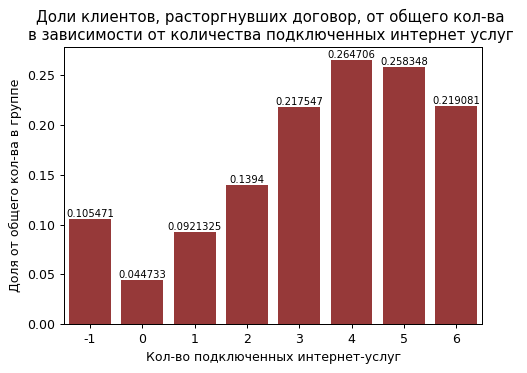

In [43]:
'''
Создаем объект Series, сгруппировав всех клиентов по количеству услуг и по факту расторгнутого/действующего договора, 
для отображения доли от общего кол-ва в группе, а не самих значений указываем параметр normalize=True
'''

services_group = df_all.groupby('count_services')['terminated'].value_counts(normalize=True)

'''
Из мультииндекса получаем значения только для клиентов, которые расторгли договор, для удобства построения графика 
переназначаем индексы, используем unstack() для превращения Series() сначала в Dataframe(), а уже к нему применяем reset_index()
'''
services_group = services_group[services_group.index.get_level_values(1) == 1].unstack().reset_index()

#строим график
plt.figure(figsize = (6,4), dpi = 90)
ax = sns.barplot(data = services_group, x = 'count_services', y = 1, color = 'brown')
#отображаем значения на каждом столбце
for i in ax.containers:
    ax.bar_label(i,fontsize=8)
plt.xlabel('Кол-во подключенных интернет-услуг') 
plt.ylabel('Доля от общего кол-ва в группе') 
plt.title('Доли клиентов, расторгнувших договор, от общего кол-ва \nв зависимости от количества подключенных интернет услуг ')
plt.show() 

**Полученный график показывает следующее:**
- наименьшая доля клиентов, расторгнувших договор, находится в группе с 0 подключенных услуг
- доля клиентов, расторгнувших договор, увеличивается в каждой группе по мере увеличения кол-ва подключенных услуг и показывает наибольшее значение в группе с 4 подключенными услугами, после чего немного уменьшается.
- доля ушедших клиентов, не имеющих интернет, от общего количества клиентов в  группе достаточна низкая и сопоставима с группой клиентов с 1 подключенной услугой 

Также из-за того, что у нас выборки разного размера для действующих/прекративших договор клиентов, то графики для непрерывных величин для столбцов с длительностью договора и суммами платежей    нужно нормализовать по плотности для того, чтобы перейти от количества к доле, тогда оценка будет более корректна. Поэтому добавим в графики для этих признаков параметры `stat='density', common_norm=False`

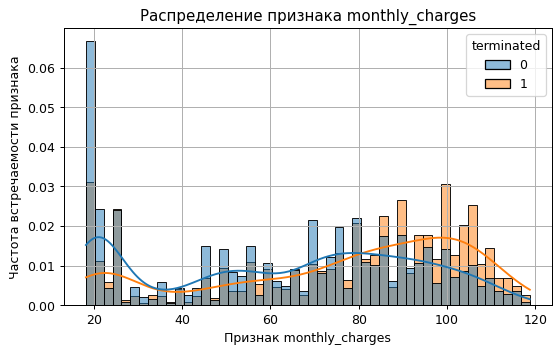

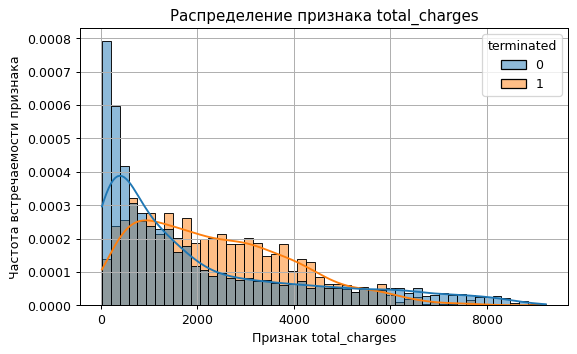

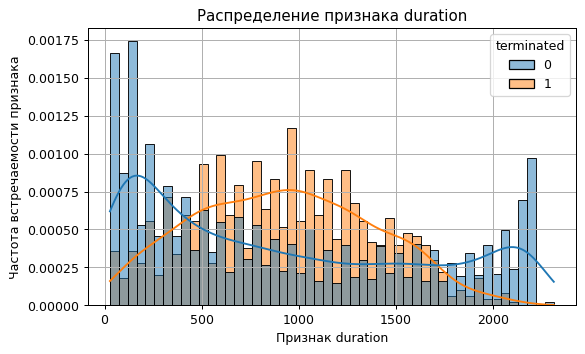

In [44]:
#выделим только количественные непрерывные признаки
for c in df_all.select_dtypes(exclude='object').columns.tolist():
    if (df_all[c].dtype == 'int64' or df_all[c].dtype == 'float') and (len(df_all[c].unique()) > 30):
        plt.figure(figsize = (7,4), dpi = 90)
        plt.grid()
        plt.ylabel('Частота встречаемости признака')
        plt.xlabel(f'Признак {c}')
        plt.title(f'Распределение признака {c}')
        sns.histplot(data = df_all, x = c, color = 'peru', bins = 50, legend=True, hue = 'terminated', kde=True, \
                    stat='density', common_norm=False)         
        plt.show()

**Полученные графики дополняют полученные результаты следующим:**
- при увеличении ежемесячной платы доля ушедших клиентов увеличивается, особенно это заметно после 80
- свыше 6000 общих платежей доля ушедших клиентов сильно снижается
- при нормализации данных по плотности видно, что доля ушедших клиентов с общими тратами от 2000 до 4000 сильно выше, чем оставшихся клиентов
- на графике длительности договора сглаживающие пересекаются в районах 400 и 1700 дней, значит, в период с 400 по 1700 день наиболее важно удержать клиента и не допустить его ухода
- до 1000 дней длительности действия договора вероятность расторжения договора возрастает, после 1000 дней вероятность этого события снижается

Теперь построим графики для категориальных признаков. Слева будут располагаться графики для всех клиентов, а справа графики с разделением на группы в зависимости от того ушел клиент или остался

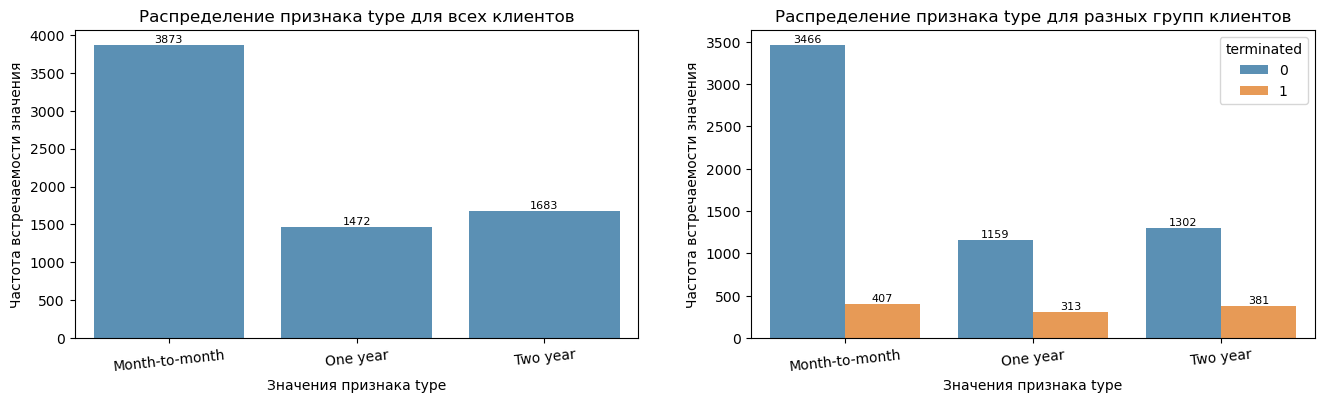

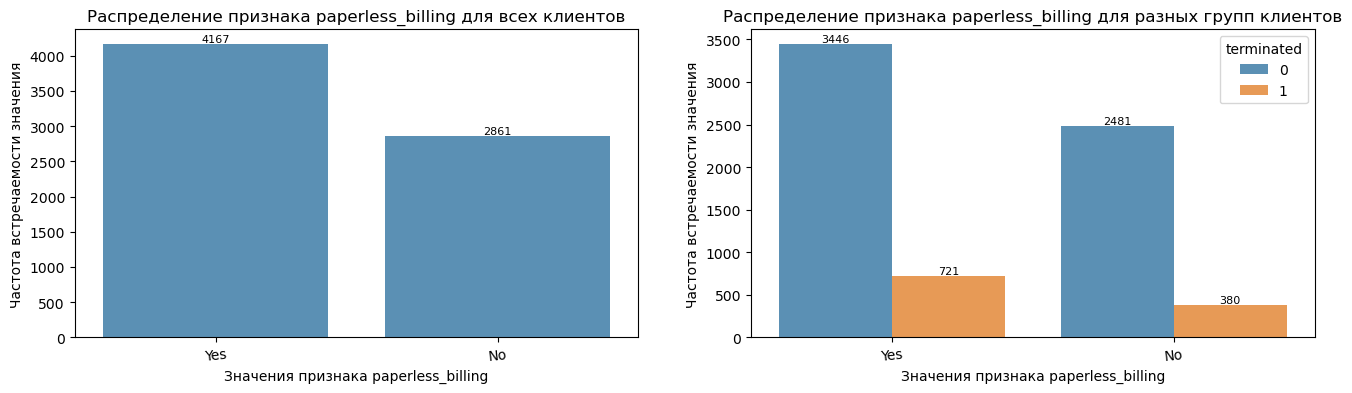

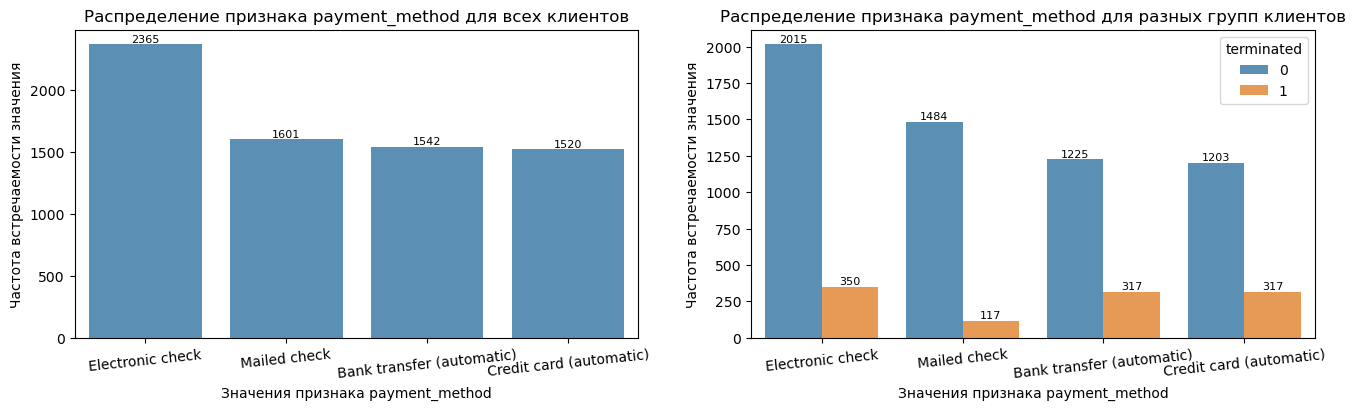

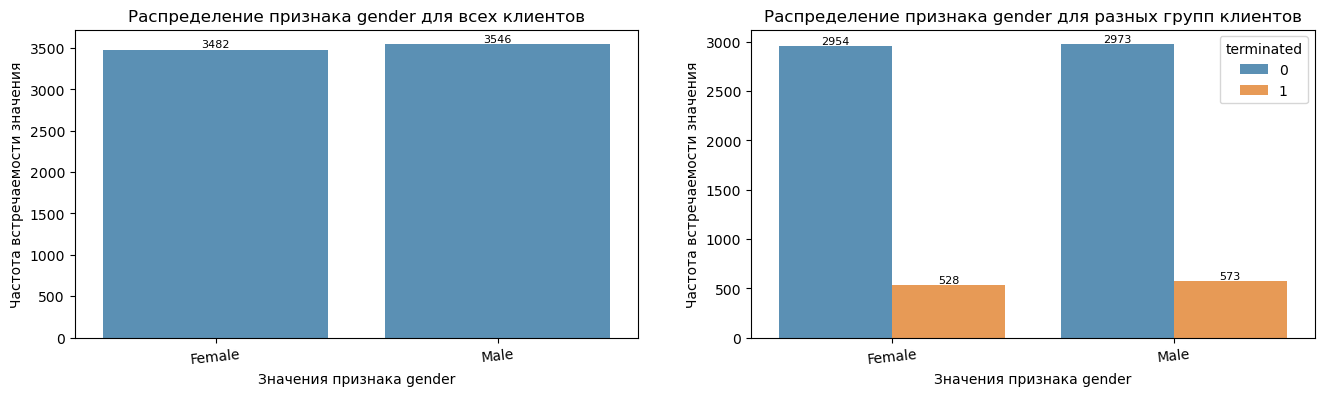

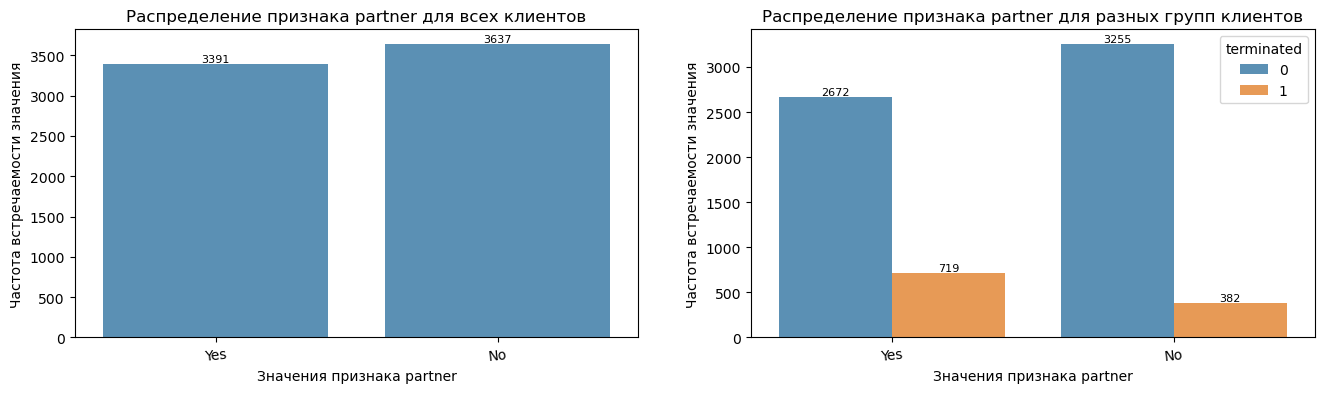

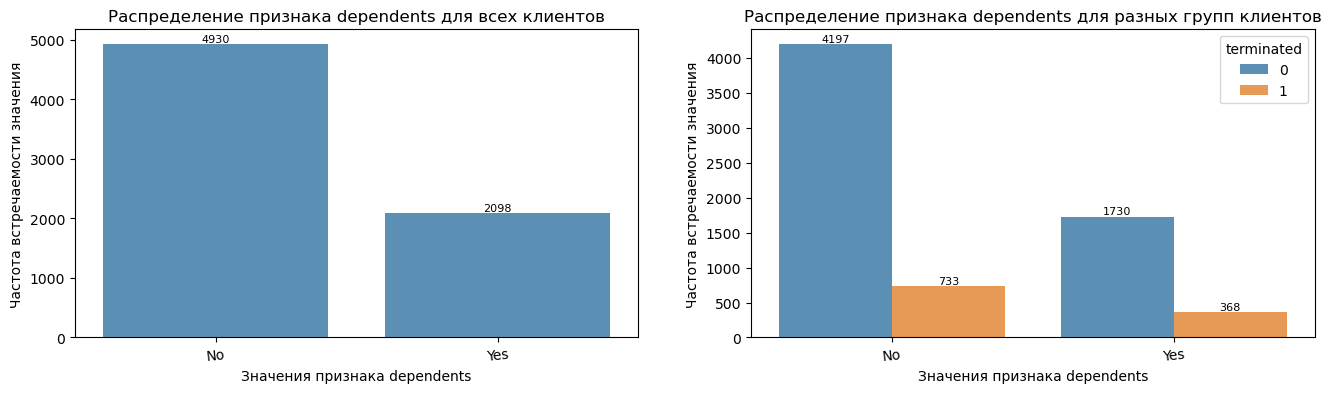

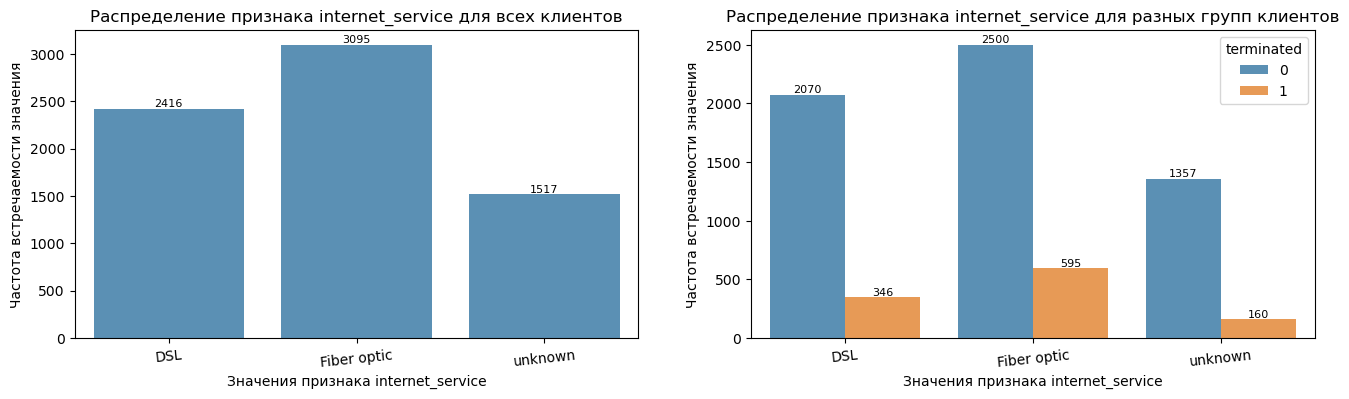

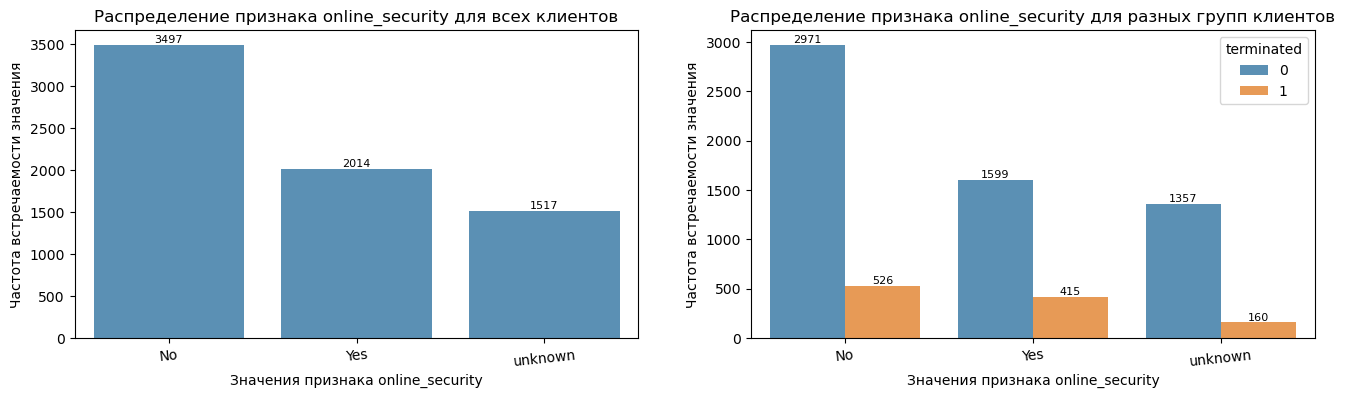

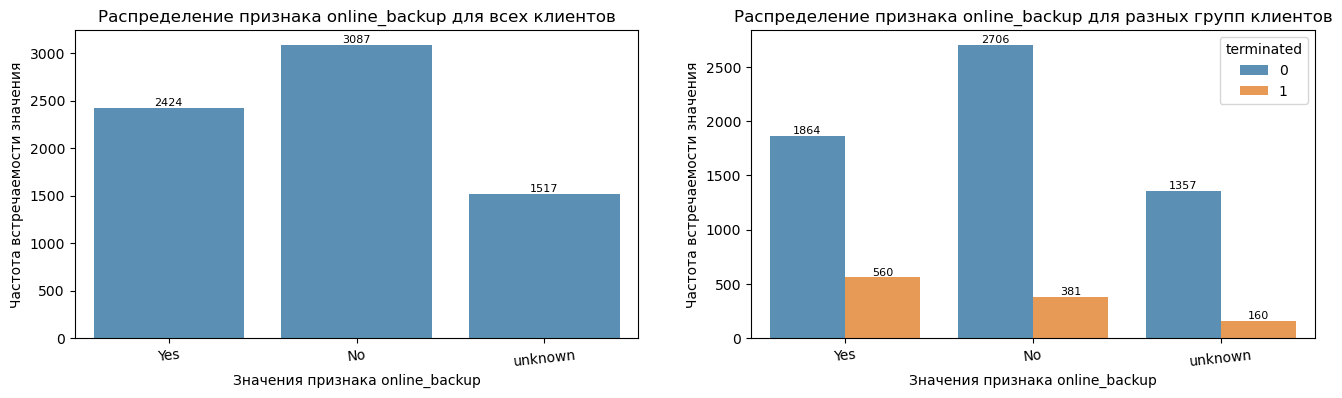

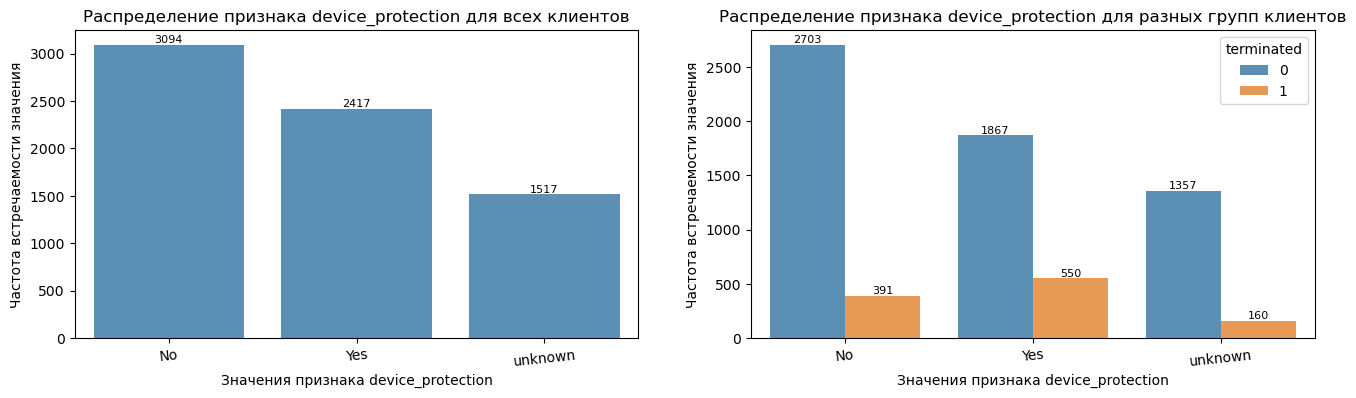

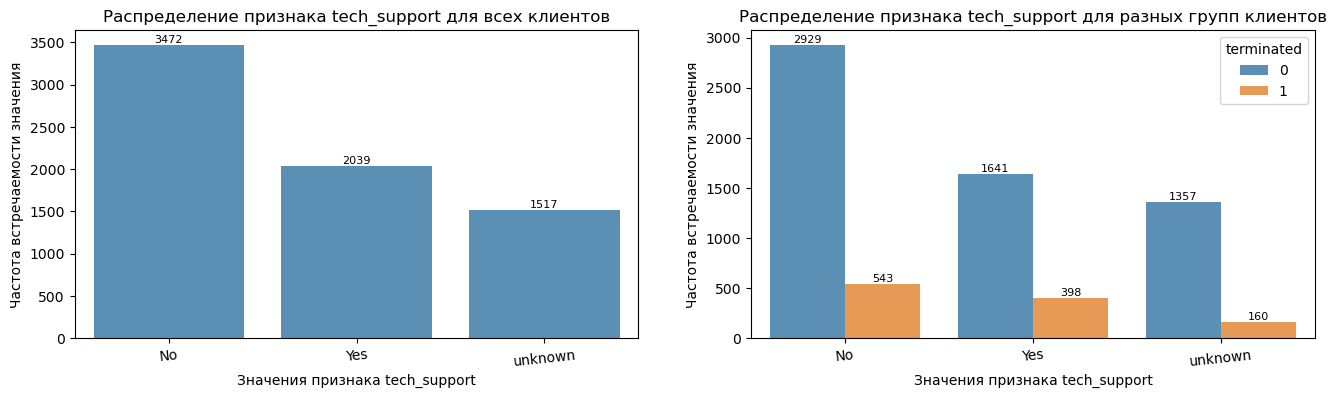

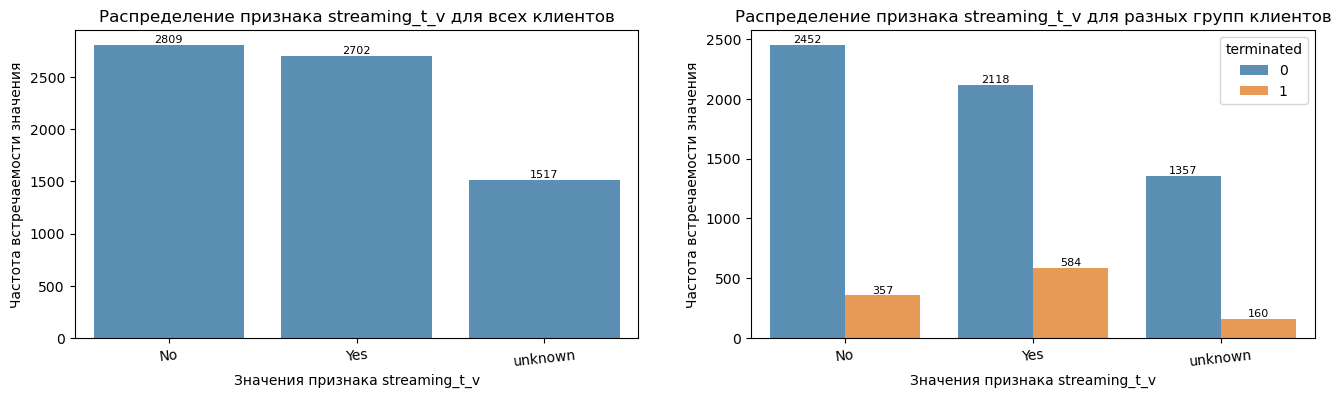

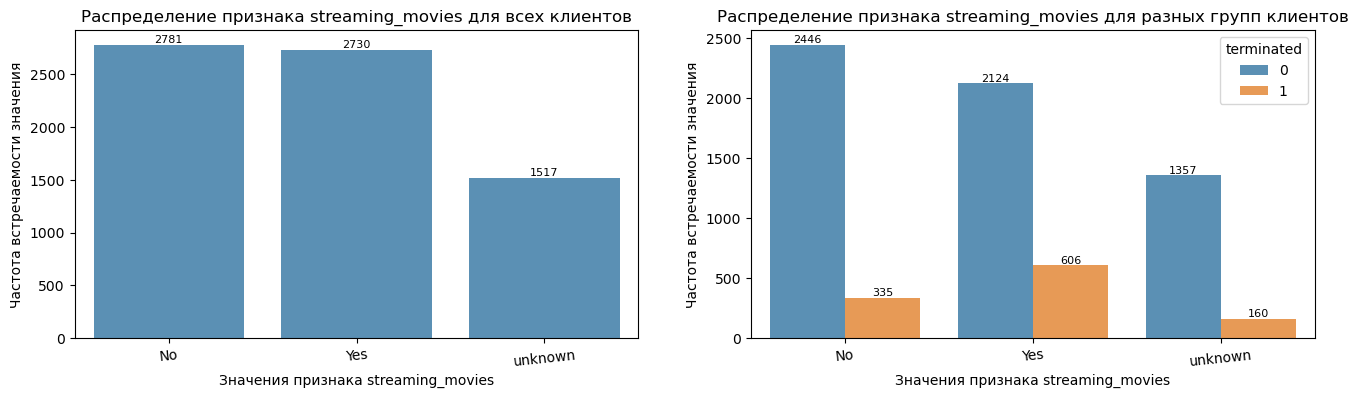

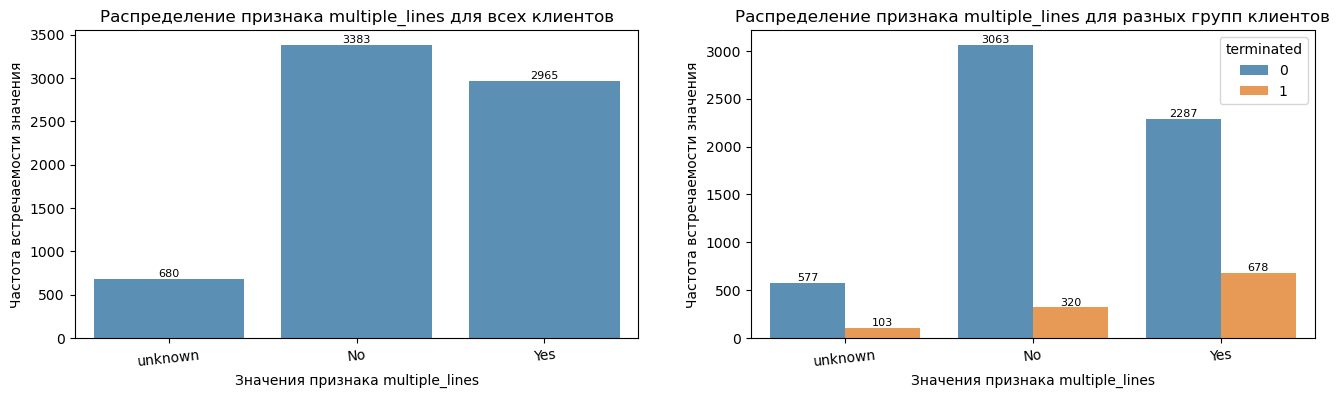

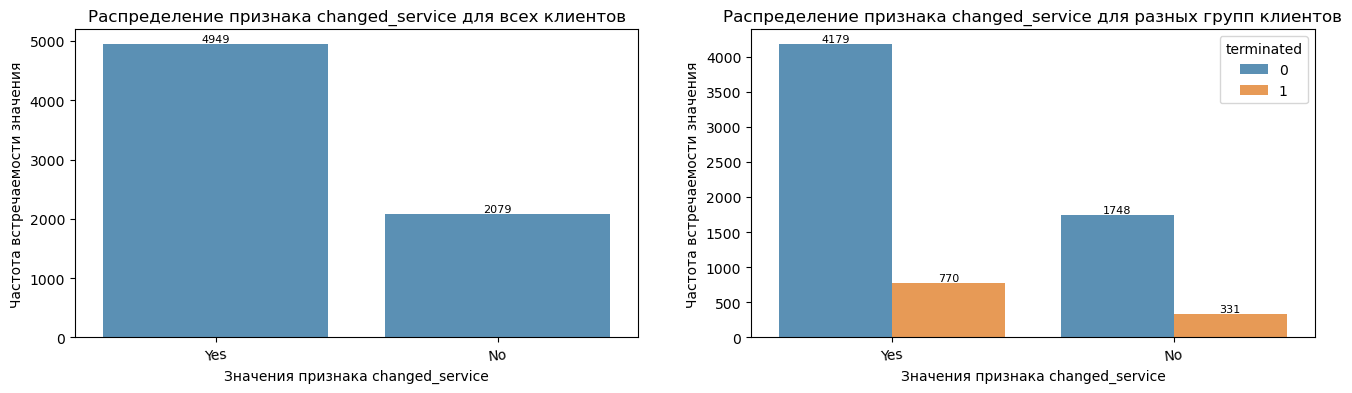

In [45]:
for c in df_all.select_dtypes(include='object').columns.tolist():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    axes[0].set_title(f'Распределение признака {c} для всех клиентов')
    axes[0].set_xlabel(f'Значения признака {c}')
    axes[0].set_ylabel('Частота встречаемости значения')
    axes[0].tick_params(axis='x', rotation=6, labelsize=10)
        
    axes[1].set_title(f'Распределение признака {c} для разных групп клиентов')
    axes[1].set_xlabel(f'Значения признака {c}')
    axes[1].set_ylabel('Частота встречаемости значения')
    axes[1].tick_params(axis='x', rotation=6, labelsize=10)
            
    #строим графики    
    ax = sns.countplot(data = df_all, x=c, alpha=0.8, ax=axes[0])
    #указываем фактические значения
    for i in ax.containers:
        ax.bar_label(i,fontsize=8)
    ax = sns.countplot(data = df_all, x=c, hue = 'terminated', alpha=0.8,ax=axes[1])
    #указываем фактические значения
    for i in ax.containers:
        ax.bar_label(i,fontsize=8)
    plt.show()

**Полученные графики показывают следующее:**
- около половины всех клиентов пользуются ежемесячным типом платежа, остальные типы платежей распределены практически поровну между собой
- доля ушедших клиентов от общего количества минимальна в группе с ежемесячным типом платежа - около 12%, для остальных типов платежей доля ушедших составляет примерно 27%
- наибольшая часть клиентов (3446) предпочитает электронный расчетный лист. Доля ушедших немного выше в группе с электронным расчетным листом
- больше всего клиенты выбирают тип платежа - электронный чек. Доля ушедших от общего количества в группе меньше всего в группе с типом платежа чека по эл. почте, в остальных группах доли ушедших примерно одинаковые.
- в признаке пол клиента общее распределение и распределение в зависимости от состояния договора примерно одинаковое, такой признак скорее всего не будет полезен для моделей, посмотрим корреляцию с целевым признаком и примем решение удалять или оставить этот признак
- клиентов в браке немного меньше, чем свободных. Доля ушедших клиентов больше более чем в два раза в группе клиентов, состоящих в браке.
- клиентов без детей примерно в два раза больше, чем с детьми. Доли ушедших клиентов в обоих группах составляют примерно 20%
- самая большая группа клиентов предпочитают Fiber optic (3095). Доля клиентов без интернета меньше всех (1517). При сравнении групп договор расторгнут/действующий видно, что доля расторгнувших договор меньше всех в группе клиентов, не имеющих интернет, около 11%, а больше всего в группе с оптическим волокном – около 24%
- во всех признаках с разными интернет-услугами доля ушедших клиентов выше в группах клиентов, где услуга подключена.
- клиенты с подключенной услугой разговора по нескольким телефонным линиям одновременно также расторгают договора намного чаще (порядка 30%), чем клиенты, у которых такая опция не подключена (порядка 10%).
- новый признак `changed_service` показывает, что клиентов, которые меняли тариф или добавляли услуги, больше чем в два раза больше, чем клиентов, которые ничего не меняли в своем тарифе. Распределение долей ушедших клиентов от общего количества в группах примерно одинаковое.

**На этапе исследовательского анализа были получены следующие результаты:**

**Полученные статистики показали следующее:**
- из даты заключения и окончания договоров видно, что предоставлены данные за период с октября 2013 года по февраль 2020
- медианное значение среднемесячных платежей за тариф и услуги составляет 70.35, а общих платежей за все время - 1345.275
- пенсионеров в наших данных около 19.4% от общего числа
- клиентов, прекративших договор, окло 18.5% от общего числа, явных дисбаланс классов, нужно будет применить стратификацию и балансировку весов в моделях
- медианное значение длительности договора составляет 2 года у данного оператора
- медианное значение подключенных интернет-услуг у пользователей - 2
- клиенты чаще меняют тариф или подключают услуги, чем ничего не меняют за все время действия договора
- если рассматривать каждую интернет-услугу, то люди чаще не пользуются ими, чем подключают
- чаще всего люди выбирают ежемесячный способ оплаты
- наибольшая часть клиентов не имеет детей и не женаты
- мужчин и женщин практически поровну среди клиентов

**Графики количественных признаков показали следующее:**
- всплески новых пользователей были в начале 2014 года и в конце 2020 года. График показывает, что до 2016 года доля ушедших от общего количества клиентов была равномерна, но после 2016 до 2020 года кол-во ушедших пользователей от общего количества заключивших договора постоянно уменьшается, при это кол-во пользователей, вновь заключивших договор, с 2016 года только растет.
- клиентов, прекративших договор, малая часть от общего кол-ва, как мы видели по статистикам, около 18.5%
- около 1000 активных клиентов предпочитают небольшие ежемесячные платежи– в области 20. У активных клиентов выделяются три сегмента по ежемесячным платежам – в областях 20, 50 и 75. У ушедших клиентов сглаживающая кривая достигает своего пика в области 90. Медианное значение ежемесячных платежей для активных клиентов – 70, а для ушедших – в области 85
- больше всего активных клиентов с общей суммой платежей до 2000, это может быть также связно с тем, что с середины 2020 года и до конца года был очень большой всплеск новых пользователей.
- медианное значение общих платежей для ушедших пользователей составляет 2100, а для действующих клиентов в районе 1200.
- свыше 5000 суммы общих платежей подавляющее большинство клиентов с действующим договором. Следовательно, чем больше и дольше человек является клиентом, тем меньше вероятность того, что он расторгнет договор
- доля ушедших пенсионеров от общего количества пенсионеров больше, чем доля ушедших клиентов среди всех остальных клиентов 
- на графике длительности действия договора виден скачек в области 150 дней, связанный с тем, что в конце 2020 года был всплеск новых пользователей. Также наблюдается пик в области более 2000 дней. По графику оставшихся-действующих клиентов также видно, доля ушедших пользователей выходит на плато области 1000 дней, где доля ушедших клиентов от общего количества максимальная, и после этого числа количество ушедших пользователей становится меньше, а после 1700 дней количество ушедших пользователей становится минимально, что еще раз подтверждает зависимость: чем длительнее становится договор, тем меньше становится вероятность того, что клиент его расторгнет
- по графику количества услуг видно, что самая большая группа – это клиенты, не пользующиеся интернетом в принципе. Для пользователей с интернетом видно, что чаще других у пользователей подключено 3 услуги. 

*Дополнительный график для групп с количеством подключенных интернет-услуг показал следующее:*
- наименьшая доля клиентов, расторгнувших договор, находится в группе с 0 подключенных услуг
- доля клиентов, расторгнувших договор, увеличивается в каждой группе по мере увеличения кол-ва подключенных услуг и показывает наибольшее значение в группе с 4 подключенными услугами, после чего немного уменьшается.
- доля ушедших клиентов, не имеющих интернет, от общего количества клиентов в  группе достаточна низкая и сопоставима с группой клиентов с 1 подключенной услугой 

*Дополнительные графики для непрерывных признаков покащали следующее:*
- при увеличении ежемесячной платы доля ушедших клиентов увеличивается, особенно это заметно после 80
- свыше 6000 общих платежей доля ушедших клиентов сильно снижается
- при нормализации данных по плотности видно, что доля ушедших клиентов с общими тратами от 2000 до 4000 сильно выше, чем оставшихся клиентов
- на графике длительности договора сглаживающие пересекаются в районах 400 и 1700 дней, значит, в период с 400 по 1700 день наиболее важно удержать клиента и не допустить его ухода
- до 1000 дней длительности действия договора вероятность расторжения договора возрастает, после 1000 дней вероятность этого события снижается

**Полученные графики для категориальных признаков показали следующее:**
- около половины всех клиентов пользуются ежемесячным типом платежа, остальные типы платежей распределены практически поровну между собой
- доля ушедших клиентов от общего количества минимальна в группе с ежемесячным типом платежа - около 12%, для остальных типов платежей доля ушедших составляет примерно 27%
- наибольшая часть клиентов (3446) предпочитает электронный расчетный лист. Доля ушедших немного выше в группе с электронным расчетным листом
- больше всего клиенты выбирают тип платежа - электронный чек. Доля ушедших от общего количества в группе меньше всего в группе с типом платежа чека по эл. почте, в остальных группах доли ушедших примерно одинаковые.
- в признаке пол клиента общее распределение и распределение в зависимости от состояния договора примерно одинаковое, такой признак скорее всего не будет полезен для моделей, посмотрим корреляцию с целевым признаком и примем решение удалять или оставить этот признак
- клиентов в браке немного меньше, чем свободных. Доля ушедших клиентов больше более чем в два раза в группе клиентов, состоящих в браке.
- клиентов без детей примерно в два раза больше, чем с детьми. Доли ушедших клиентов в обоих группах составляют примерно 20%
- самая большая группа клиентов предпочитают Fiber optic (3095). Доля клиентов без интернета меньше всех (1517). При сравнении групп договор расторгнут/действующий видно, что доля расторгнувших договор меньше всех в группе клиентов, не имеющих интернет, около 11%, а больше всего в группе с оптическим волокном – около 24%
- во всех признаках с разными интернет-услугами доля ушедших клиентов выше в группах клиентов, где услуга подключена.
- клиенты с подключенной услугой разговора по нескольким телефонным линиям одновременно также расторгают договора намного чаще (порядка 30%), чем клиенты, у которых такая опция не подключена (порядка 10%).
- новый признак `changed_service` показывает, что клиентов, которые меняли тариф или добавляли услуги, больше чем в два раза больше, чем клиентов, которые ничего не меняли в своем тарифе. Распределение долей ушедших клиентов от общего количества в группах примерно одинаковое.

Следующим этапом проведем корреляционный анализ

## Корреляционный анализ

Следующим шагом необходимо посмотреть взаимосвязи входных признаков, чтобы устранить мультиколлинеарность при ее наличии и проверить необходимость двух признаков, которые были выявлены на этапе исследовательского анализа - `gender` и `changed_service` . Воспользуемся матрицей корреляции из библиотеки `phik`, передав список столбцов с непрерывными значениями. Столбцы с временным типом данных в `interval_cols` не передаются

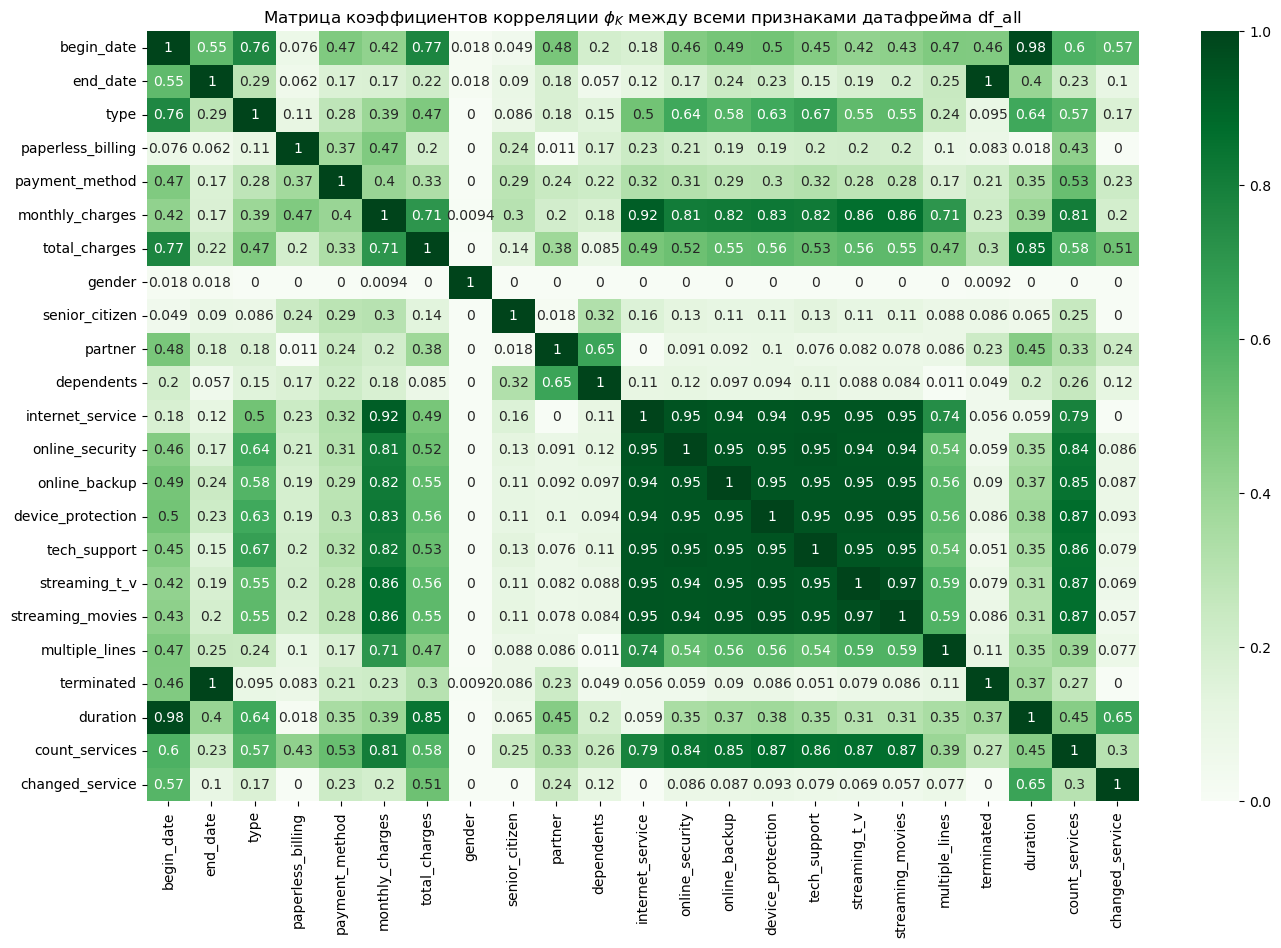

In [46]:
interval_cols = [
    'monthly_charges',
    'total_charges',
    'duration'
]

plt.figure(figsize = (16,10))
sns.heatmap(df_all.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между всеми признаками датафрейма df_all')
plt.show()

**Полученная матрица корреляции показывает следующее:**
- присутствует мультиколлинеарность между всеми входными признаками с интернет услугами. Так как мы создали новый признак с количество услуг `count_services`, который коррелирует с целевым признаком `terminated`(коэффициент корреляции 0.27), то уберем мультиколлинеарность и удалим все признаки с интернет-услугами: `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies`, коэффициент корреляции у которых с целевыми признаком не выше 0.09
- целевой признак `terminated` был создан на основе столбца `end_date`, поэтому теперь у них коэффициент корреляции между собой 1, из-за этого этот признак может сильно взять на себя роль самого важного признака и тем самым исказить результаты работы моделей. Также удалим этот признак.
- столец `begin_date` также имеет мультиколлинеарность с другим новым признаком `duration`. Столбец с временным типом данных напрямую в модель передать нельзя. До этого мы столбец с временным типом данных при работе модели использовали только в теме про временные ряды в задаче регрессии, когда из него создавали признаки месяц, день, день недели, разности ряда, когда исследовали тренды и сезонность. В текущей задаче думаю нет смысла переводить в целочисленный тип этот столбец или на его основе получать дни или месяцы, поэтому удалим именно этот признак и оставим признак `duration`.
- признак `gender` подтвердил результаты исследовательского анализа - он не имеет корреляции с целевым признаком, удалим его
- признак `internet_service` имеет мультиколлинеарность с другим входны признаком - `monthly_charges`. Но так как `monthly_charges` имеет коэффициент корреляции с целевым признаком 0.23, а `internet_service` 0.056, то удалим именно признак `internet_service` и устраним мультиколлинеарность
- новые признаки `count_services` и `duration` показали корреляцию с целевым признаком выше, чем у остальных признаков, будем использовать их в обучении
- новый признак `changed_service` не имеет корреляции с целевым признаком, поэтому его при обучении моделей использовать не будем

Уберем выбранные признаки 'begin_date', 'end_date', 'gender', 'changed_service', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v','streaming_movies' и заново построим матрицу корреляции с отобранными признаками для обучения

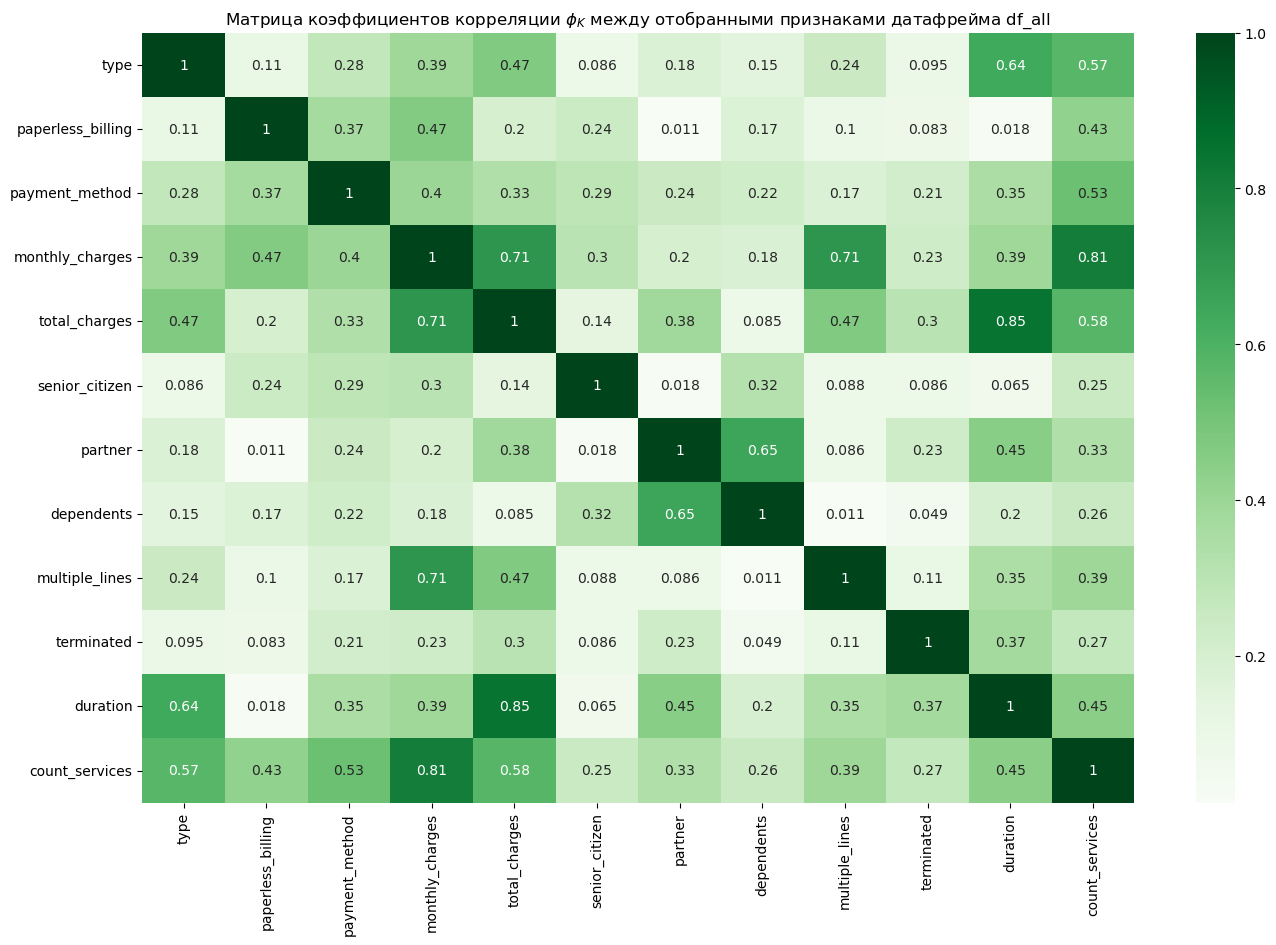

In [47]:
interval_cols = [
    'monthly_charges',
    'total_charges',
    'duration'
]

plt.figure(figsize = (16,10))
sns.heatmap(df_all.drop(['begin_date', 'end_date', 'gender', 'changed_service', 'internet_service',\
            'online_security', 'online_backup', 'device_protection', 'tech_support',\
            'streaming_t_v','streaming_movies'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между отобранными признаками датафрейма df_all')
plt.show()

**Матрица корреляции с отобранными признаками для обучения показывает следующее:**
- мультиколлинеарность между входными признаками устранена
- наибольшая корреляция с целевым признаком у признаков `duration`(0.37) и `count_services`(0.27)
- наблюдается высокая корреляция между входными признаками `duration` и `total_charges` - 0.85 и между `count_services` и `monthly_charges` - 0.81

**На этапе корреляционного анализа полученная матрица со всеми входными признаками показала следующее:**
- присутствует мультиколлинеарность между всеми входными признаками с интернет услугами. Так как мы создали новый признак с количество услуг `count_services`, который коррелирует с целевым признаком `terminated`(коэффициент корреляции 0.27), то уберем мультиколлинеарность и удалим все признаки с интернет-услугами: `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies`, коэффициент корреляции у которых с целевыми признаком не выше 0.09
- целевой признак `terminated` был создан на основе столбца `end_date`, поэтому теперь у них коэффициент корреляции между собой 1, из-за этого этот признак может сильно взять на себя роль самого важного признака и тем самым исказить результаты работы моделей. Также удалим этот признак.
- столец `begin_date` также имеет мультиколлинеарность с другим новым признаком `duration`. Столбец с временным типом данных напрямую в модель передать нельзя. До этого мы столбец с временным типом данных при работе модели использовали только в теме про временные ряды в задаче регрессии, когда из него создавали признаки месяц, день, день недели, разности ряда, когда исследовали тренды и сезонность. В текущей задаче думаю нет смысла переводить в целочисленный тип этот столбец или на его основе получать дни или месяцы, поэтому удалим именно этот признак и оставим признак `duration`.
- признак `gender` подтвердил результаты исследовательского анализа - он не имеет корреляции с целевым признаком, удалим его
- признак `internet_service` имеет мультиколлинеарность с другим входны признаком - `monthly_charges`. Но так как `monthly_charges` имеет коэффициент корреляции с целевым признаком 0.23, а `internet_service` 0.056, то удалим именно признак `internet_service` и устраним мультиколлинеарность
- новые признаки `count_services` и `duration` показали корреляцию с целевым признаком выше, чем у остальных признаков, будем использовать их в обучении
- новый признак `changed_service` не имеет корреляции с целевым признаком, поэтому его при обучении моделей использовать не будем

***После удаления признаков `begin_date`, `end_date`, `gender`, `changed_service`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies` из датасета матрица корреляции была построена повторно и показала следующее:***

- мультиколлинеарность между входными признаками устранена
- наибольшая корреляция с целевым признаком у признаков `duration`(0.37) и `count_services`(0.27)
- наблюдается высокая корреляция между входными признаками `duration` и `total_charges` - 0.85 и между `count_services` и `monthly_charges` - 0.81

Следующим этапом будет обучение моделей

## Обучение моделей

В нашем исследовании будем использовать несколько моделей классификации: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC() и две модели бустинга - CatBoostClassifier() и LGBMClassifier(). Так как модели бустинга обучаются долго, особенно долго обучается LGBMRegressor(), то у них возьмем небольшой набор гиперпараметров. Так как у моделей бустинга, линейной модели и SVC() будет мало гиперпараметров, то для них будем использовать GridSearchCV(), а для моделей DecisionTreeClassifier() и KNeighborsClassifier() будем использовать RandomizedSearchCV(). Для удобства будем использовать пайплайны. Итоговые результаты по качеству и времени работы моделей получим из таблиц cv_results_. Также посмотрим время работы при помощи метода .time(), посчитав сколько времени занимает именно выполнение автоматизированного подбора гиперпараметров из всего кода в ячейке. Данные подготовим при помощи ColumnTransformer.

### Отбор признаков и разбиение на выборки

Сперва разобьем данные на две выборки в соотношении 3:1, убрав лишние признаки `begin_date`, `end_date`, `gender`, `changed_service`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies` Так как у нас есть большой дисбаланс целевого признака, то для сохранения пропорций разных групп в целевом признаке укажем параметр `stratify`.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    df_all.drop(['begin_date', 'end_date', 'gender', 'changed_service', 'internet_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support',
            'streaming_t_v','streaming_movies','terminated'], axis=1),
    df_all['terminated'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=df_all['terminated']
)

Проверим размерности полученных выборок

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5271, 11)
(1757, 11)
(5271,)
(1757,)


**На основании исследовательского и корреляционного анализа из датасета были отобраны признаки для обучения моделей, данные были разбиты на тренировочную и тестовую выборки**. 

Теперь приступим к подготовке данных для обучения

### Подготовка данных при помощи ColumnTransformer

Чтобы не было утечки данных при подсчете метрики кросс-валидацией, то подготовка данных при помощи кодировщиков и скейлеров должна быть отдельным шагом пайплайна. Если трансформируем всю тренировочную выборку до кросс-валидации, то потом при автоматизированном подборе гиперпараметров и подсчете метрики при кросс-валидации произойдет разделение тренировочных данных на фолды, которые уже были трансформированы — это приведет к утечке, потому что информация из валидационного фолда уже будет "вшита" в обученные параметры кодировщиков и скейлеров. Поэтому будем использовать `Pipeline`, где все трансформеры внутри себя сначала разделят данные, потом на каждом фолде обучатся на тренировочной части, и только потом оценят на валидационной.

- так как мы будем использовать линейную модель, то для нее важно задать порядок значений в признаках, которые поддаются ранжированию, для них будем использовать OrdinalEncoder(). Поэтому к признакам `type`, `paperless_billing`, `partner`, `dependents`, `multiple_lines` будем применять `OrdinalEncoder()`
- признак `payment_method`, который номинальный и ранжированию не поддается, будем кодировать при помощи OneHotEncoder() (хоть признак `payment_method` и имеет 4 уникальных значения, а значит при кодировании в OHE и при применении параметра `drop=first` создастся 3 новых столбца, что не пойдет на пользу нелинейным моделям, но у нас также есть и линейная модель классификации, которая может найти взаимосвязи там где их нет, если мы передадим этот столбец с  в OrdinalEncoder(). Поэтому хоть мы и создадим 3 новых признака, что не пойдет на пользу нелинейным моделям, но зато не запутает линейную.
- хоть у нас нет пропусков в категориальных столбцах, но при использовании кодировщиков OneHotEncoder() и OrdinalEncoder() добавим обработку пропусков и замену их на моды при помощи SimpleImputer() в целях унификации на тот случай, если будут новые данные и в них уже будут пропуски.
- количественные признаки будем масштабировать изначально при помощи `StandardScaler()`, потом через словарь с гиперпараметрами добавим еще для некоторых моделей `passthrough`.

**Разделение признаков на порядковые и номинальные будет следующим:**
 - `payment_method` нельзя проранжировать, поэтому его будем кодировать при помощи OneHotEncoder()
 - `type`, `paperless_billing`, `partner`, `dependents`, `multiple_lines` можно проранжировать, поэтому для них создадим словарь `categories` и будем кодировать при помощи `OrdinalEncoder()`.

Целевой признак имеет всего два значения, поэтому LaberEncoder() к нему для ускорения вычислений применять не будем в пайплайне

Для начала создадим отдельные списки для столбцов, которые будут масштабироваться и кодироваться разными способами.

In [50]:
ohe_columns = ['payment_method']

ord_columns = ['type',
               'paperless_billing',
               'partner',
               'dependents',
               'multiple_lines']

num_columns = ['monthly_charges',
               'total_charges',
               'senior_citizen',
               'duration',
               'count_services'] 

Создадим общий пайплайн для предобработки данных, включающий замену неизвестных категорий при кодировании в OrdinalEncoder() на самое частое значение в данном категориальном столбце при помощи SimpleImputer(). Не забываем создать словарь`categories`, чтобы передать его в OrdinalEncoder() с указанием всех ранжированных признаков

In [51]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков (хоть в данном случае у нас их нет,
#но оставим сразу для использования в будущем) и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + Ord
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(
                categories=[
                    ['Month-to-month', 'One year','Two year'], 
                    ['No', 'Yes'],
                    ['No','Yes'],
                    ['No','Yes'],
                    ['unknown', 'No','Yes']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['payment_method']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalE...
                                                          

**Создан пайплайн `data_preprocessor` для подготовки данных, включающий масштабирование данных и кодирование с обработкой пропусков**

### Обучение моделей

#### Обучение моделей LogisticRegression() и SVC()

Первыми обучим базовую линейную модель LogisticRegression() и модель SVC(). Возьмем небольшие диапазоны гиперпараметра `C` для моделей. У модели SVC оставим только нелинейные ядра `rbf` и `sigmoid` и гиперпараметр `C`, так как если указать остальные ядра и гамму еще и со своим диапазоном значений, то время расчетов сильно увеличивается. У модели SVC указываем параметр `probability = True` для работы с вероятностями. У модели логистической регрессии оставим только аглоритм `lbfgs`, использующийся по умолчанию, работающий с `l2` регуляризацией, также укажем в гиперпараметрах вариант с автоматической балансировкой весов модели `class_weight=balanced`.  Так как гиперпараметров не много и диапазоны небольшие, то для автоматизированного поиска будем использовать `GridSearchCV()`, кол-во блоков при кросс-валидации укажем 5.

In [52]:
pipeline_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

param_grid_one = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(max_iter=1000, 
                                      solver = 'lbfgs')],
        'models__C': range(3,10),
        'models__penalty': ['l2'],
        'models__class_weight' : ['balanced', None],
        'preprocessor__num': [StandardScaler()]
        },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf', 'sigmoid'],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler()]
        }
]

start = time.time()

grid_one = GridSearchCV(
    pipeline_one, 
    param_grid=param_grid_one, 
    cv=5, 
    scoring= 'roc_auc',
    n_jobs=-1
)


grid_one.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('\n\nХарактеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')

print('Лучшая модель и её параметры на тренировочном датасете:\n\n', grid_one.best_estimator_)
print('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:\n', grid_one.best_score_)



Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 24.239046812057495
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['payment_method']),
                                               

*Лучшей моделью оказалась SVC(C=3, probability=True), взглянем на таблицу с результатами для лучших моделей первого пайплайна*

In [53]:
#получаем таблицу с работой всех моделей
result_models_one = pd.DataFrame(grid_one.cv_results_).sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_one[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
18,1,"SVC(probability=True, random_state=50525)",0.744122,5.791137,0.395001,"{'models': SVC(probability=True, random_state=50525), 'models__C': 3, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
20,2,"SVC(probability=True, random_state=50525)",0.742241,6.872419,0.405782,"{'models': SVC(probability=True, random_state=50525), 'models__C': 4, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
16,3,"SVC(probability=True, random_state=50525)",0.741873,5.904752,0.391096,"{'models': SVC(probability=True, random_state=50525), 'models__C': 2, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
22,4,"SVC(probability=True, random_state=50525)",0.740891,5.773886,0.326134,"{'models': SVC(probability=True, random_state=50525), 'models__C': 5, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
14,5,"SVC(probability=True, random_state=50525)",0.740033,5.624102,0.396298,"{'models': SVC(probability=True, random_state=50525), 'models__C': 1, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
8,6,LogisticRegression(max_iter=1000),0.737637,0.093678,0.029559,"{'models': LogisticRegression(max_iter=1000), 'models__C': 7, 'models__class_weight': 'balanced', 'models__penalty': 'l2', 'preprocessor__num': StandardScaler()}"
10,7,LogisticRegression(max_iter=1000),0.737624,0.096315,0.025165,"{'models': LogisticRegression(max_iter=1000), 'models__C': 8, 'models__class_weight': 'balanced', 'models__penalty': 'l2', 'preprocessor__num': StandardScaler()}"
6,8,LogisticRegression(max_iter=1000),0.737622,0.088906,0.021751,"{'models': LogisticRegression(max_iter=1000), 'models__C': 6, 'models__class_weight': 'balanced', 'models__penalty': 'l2', 'preprocessor__num': StandardScaler()}"
12,9,LogisticRegression(max_iter=1000),0.737618,0.076477,0.024625,"{'models': LogisticRegression(max_iter=1000), 'models__C': 9, 'models__class_weight': 'balanced', 'models__penalty': 'l2', 'preprocessor__num': StandardScaler()}"
4,10,LogisticRegression(max_iter=1000),0.737614,0.081407,0.021334,"{'models': LogisticRegression(max_iter=1000), 'models__C': 5, 'models__class_weight': 'balanced', 'models__penalty': 'l2', 'preprocessor__num': StandardScaler()}"


Полученная таблица показывает, что первые 5 первых позиций занимает модель SVC() с нелинейным ядром `rbf`, метрика ROC-AUC лучшей модели - 0.744. Так как из таблицы видно, что у лучших моделей SVC() и LogisticRegression() использовались не крайние значения гиперпараметра `C`, то увеличивать диапазон значений особого смысла нет, перейдем сразу к следующим моделям. 

**При обучении моделей SVC() и LogisticRegression() на первом этапе обучения лучшей моделью оказалась модель SVC(C=3,kernel='rbf'), ROC-AUC при кросс-валидации составила 0.744**

#### Обучение моделей DecisionTreeClassifier() и KNeighborsClassifier()

Создадим новый пайплайн для обучения моделей DecisionTreeClassifier() и KNeighborsClassifier(). Так как модель DecisionTreeClassifier() не чувствительна к масштабированию данных, то укажем в гиперпараметрах модели также вариант без масштабирования `passthrough`. Так как у деревянной модели зададим несколько гиперпараметров со своими диапазонами значений, то для ускорения подбора лучших гиперпараметров лучше использовать `OptunaSearchCV()`, но она не умеет работать в пайплайне, а если мы вручную сначала произведем кодировку и масштабирование данных всей тренировочной выборки, а потом будем считать метрику кросс-валидацией, то у нас будет утечка в данных и метрика будет завышена, поэтому для автоматизированного поиска будем использовать `RandomizedSearchCV()`, просто указав сразу большое значение итераций `n_iter=500`. У модели KNeighborsClassifier() зададим небольшой диапазон значения гиперпараметра `n_neighbors` до 19 и также укажем вариант без маcштабирования.

In [54]:
pipe_two = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

param_rend = [
    # словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf': range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(),'passthrough']
    },
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(),'passthrough']   
    }
]

# запускаем таймер для проверки длительности поиска при RandomizedSearchCV
start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_two, 
    param_distributions=param_rend, 
    cv=5, 
    scoring= 'roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=500
)
randomized_search.fit(X_train, y_train) 

randomized_search_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_time}')


print('Лучшая модель и её параметры на тренировочном датасете:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 19.088359117507935
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['payment_method']),
                                           

Итоговая метрика увеличилась по сравнению с предыдущими моделями, но не достигла нужного значения. 

***Лучшей моделью оказалась модель DecisionTreeClassifier(max_depth=6, max_features=5,min_samples_leaf=2, min_samples_split=6,StandardScaler()) с метрикой ROC-AUC при кросс-валидации 0.792).***

Взглянем на таблицу результатов для 10 лучших моделей

In [55]:
#получаем таблицу с работой всех моделей
result_models_two = pd.DataFrame(randomized_search.cv_results_).sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_two[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
280,1,DecisionTreeClassifier(random_state=50525),0.792197,0.057156,0.020643,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_features': 5, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
488,2,DecisionTreeClassifier(random_state=50525),0.791146,0.056587,0.016262,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
80,3,DecisionTreeClassifier(random_state=50525),0.791070,0.063737,0.020459,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
162,4,DecisionTreeClassifier(random_state=50525),0.791048,0.073026,0.022048,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
253,5,DecisionTreeClassifier(random_state=50525),0.790940,0.069278,0.018722,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 1, 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
395,6,DecisionTreeClassifier(random_state=50525),0.790757,0.071900,0.024543,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_features': 7, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
301,7,DecisionTreeClassifier(random_state=50525),0.787571,0.074768,0.021752,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 7, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
92,8,DecisionTreeClassifier(random_state=50525),0.787120,0.081596,0.025043,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 1, 'models__max_features': 8, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
84,9,DecisionTreeClassifier(random_state=50525),0.786486,0.079611,0.025479,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=50525)}"
391,9,DecisionTreeClassifier(random_state=50525),0.786486,0.079602,0.025060,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=50525)}"


**Из полученной таблицы видно:**
- модели kNN() не хватило диапазонов значения `n_neighbors`, чтобы попасть в число лучших моделей
- значения параметров модели DecisionTreeClassifier() являются не крайними в указанных диапазонах перед обучением, поэтому расширение диапазонов гиперпараметров для повторного обучения производить не будем

**Лучшей моделью оказалась модель `DecisionTreeClassifier(max_depth=6, max_features=5,min_samples_leaf=2, min_samples_split=6, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.792`**

Попробуем улучшить метрику модели KNeighborsClassifier(), увеличив число ближайших соседей `n_neighbors` до 80. Создадим новый пайплайн только для этой модели, в качестве инструмента для поиска гиперпараметров используем GridSearchCV(), чтобы быть уверенными в том, что были использованы все значения для гиперпараметра.

In [56]:
pipeline_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid_knn = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,80),
        'preprocessor__num': [StandardScaler(),'passthrough']   
    }
]

start = time.time()

grid_knn = GridSearchCV(
    pipeline_knn, 
    param_grid=param_grid_knn, 
    cv=5, 
    scoring= 'roc_auc',
    n_jobs=-1
)


grid_knn.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('\n\nХарактеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')

print('Лучшая модель и её параметры на тренировочном датасете:\n\n', grid_knn.best_estimator_)
print('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:\n', grid_knn.best_score_)



Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 8.436617374420166
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['payment_method']),
                                                

Благодаря увеличению диапазона значений гиперпараметра `n_neighbors` до 80 удалось улучшить метрику модели KNeighborsClassifier():
- **лучшей моделью оказалась модель `KNeighborsClassifier(n_neighbors=66,StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.803`**

Посмотрим на таблицу для 10 лучших моделей

In [57]:
#получаем таблицу с работой всех моделей
result_models_knn = pd.DataFrame(grid_knn.cv_results_).sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_knn[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
128,1,KNeighborsClassifier(),0.803242,0.076028,0.171426,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 66, 'preprocessor__num': StandardScaler()}"
130,2,KNeighborsClassifier(),0.803181,0.092455,0.162210,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 67, 'preprocessor__num': StandardScaler()}"
122,3,KNeighborsClassifier(),0.802915,0.088336,0.178447,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 63, 'preprocessor__num': StandardScaler()}"
126,4,KNeighborsClassifier(),0.802876,0.082786,0.155313,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 65, 'preprocessor__num': StandardScaler()}"
132,5,KNeighborsClassifier(),0.802873,0.083903,0.171819,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 68, 'preprocessor__num': StandardScaler()}"
124,6,KNeighborsClassifier(),0.802598,0.084509,0.165478,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 64, 'preprocessor__num': StandardScaler()}"
118,7,KNeighborsClassifier(),0.802532,0.090764,0.178990,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 61, 'preprocessor__num': StandardScaler()}"
136,8,KNeighborsClassifier(),0.802359,0.085761,0.163257,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 70, 'preprocessor__num': StandardScaler()}"
120,9,KNeighborsClassifier(),0.802336,0.090662,0.176492,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 62, 'preprocessor__num': StandardScaler()}"
140,10,KNeighborsClassifier(),0.802283,0.099763,0.187558,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 72, 'preprocessor__num': StandardScaler()}"


Из полученной таблицы видно, что крайние значения диапазона гиперпараметра `n_neighbors` не использовались у лучших 10 моделей, поэтому дальнейшее увеличение диапазона гиперпараметра производить не будем.

**При обучении моделей DecisionTreeClassifier() и KNeighborsClassifier() и автоматизированном подборе гиперпараметров были получены следующие лучшие модели каждого типа:**
- ***лучшая модель `DecisionTreeClassifier(max_depth=6, max_features=5, min_samples_leaf=2, min_samples_split=6, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.792`***
- ***лучшая модель `KNeighborsClassifier(n_neighbors=66, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.803`***

#### Обучение моделей CatBoostClassifier() и LGBMClassifier()

Попробуем улучшить метрику качества, обучив модели бустинга CatBoostClassifier() и LGBMClassifier(). Так как мы предварительно кодировали категориальные столбцы, то передавать список с категориальными столбцами в модели не нужно, так как это приведет к ошибке. Так как данные модели обучаются намного дольше, чем все предыдущие, то зададим небольшие диапазоны значений при подборе гиперпараметров и уменьшим кол-во блоков при кросс-валидации до 3.

In [58]:
pipe_boost = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier())
])

param_grid_boost = [
    # словарь для модели CatBoostClassifier()
    #так как мы предварительно кодировали данные, то список cat_features с категориальными столбцами передавать не нужно
    {
        'models': [CatBoostClassifier(verbose = 0, 
                                     loss_function='Logloss',
                                     eval_metric='AUC',
                                     l2_leaf_reg=3,
                                     random_seed = RANDOM_STATE)],
        'models__depth': range(2,7),
        'models__iterations' : [800, 1100, 1400],
        'models__learning_rate': [0.03, 0.1],
        'preprocessor__num': [StandardScaler()]
        
            },
    #словарь для модели LGBMClassifier()
        {
        'models': [LGBMClassifier(verbose = -1,
                                 n_estimators = 1000,  
                                 metric='auc')],
        'models__num_leaves': [15, 31],
        'models__learning_rate': [0.05, 0.1],
        'models__max_depth': range(3,6),
        'preprocessor__num': [StandardScaler()]
    }
]

start = time.time()

grid_boost = GridSearchCV(
    pipe_boost, 
    param_grid=param_grid_boost, 
    cv=3, 
    scoring= 'roc_auc',
    n_jobs=-1
)
grid_boost.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('\n\nХарактеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')

print('Лучшая модель и её параметры на тренировочном датасете:\n\n', grid_boost.best_estimator_)
print('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:\n', grid_boost.best_score_)



Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 139.22974729537964
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['payment_method']),
                                               

Итоговая метрика сильно увеличилась по сравнению с предыдущими моделями и достигла нужного значения, проверим данную модель на тестовых данных.

***Лучшей моделью оказалась модель CatBoostClassifier() с метрикой ROC-AUC при кросс-валидации 0.913, лучшая модель была подобрана за 140 секунд***

Взглянем на таблицу результатов для 10 лучших моделей

In [59]:
#получаем таблицу с работой всех моделей
result_models_boost = pd.DataFrame(grid_boost.cv_results_).sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_boost[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
11,1,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.913179,20.595247,0.159662,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 3, 'models__iterations': 1400, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
5,2,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.912634,17.730593,0.158407,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 2, 'models__iterations': 1400, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
9,3,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.910850,16.497868,0.161154,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 3, 'models__iterations': 1100, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
17,4,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.910362,24.189598,0.141648,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 4, 'models__iterations': 1400, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
15,5,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.909711,19.281094,0.153921,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 4, 'models__iterations': 1100, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
13,6,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.908159,14.501346,0.156794,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 4, 'models__iterations': 800, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
3,7,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.907595,13.882227,0.165105,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 2, 'models__iterations': 1100, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
7,8,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.906336,12.415818,0.160970,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 3, 'models__iterations': 800, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
21,9,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.905167,22.854894,0.146881,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 5, 'models__iterations': 1100, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
19,10,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.904943,16.895123,0.148442,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 5, 'models__iterations': 800, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"


**Полученная таблица показывает следующее:**
- в десятку лучших моделей входят только модели CatBoostClassifier(), ни одна из моделей LGBMClassifier() не оказалась в числе лучших
- увеличенный диапазон `iterations` до 1400 со стандартного 1000 позволил улучшить итоговую метрику
- оптимальный шаг обучения `learning_rate` для всех лучших 10 моделей оказался 0.1
- значение параметра `depth` для лучших моделей оказалось не крайним значением из указанного диапазона для обучения, поэтому увеличивать диапазон значений для этого параметра не будем

***Лучшей моделью третьего этапа обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913`***

Проведем анализ результатов обучения всех моделей

### Сравнение результатов обученных моделей

Составим итоговую таблицу с результатами из лучших моделей каждого этапа и выберем лучшую

In [60]:
pd.concat([
        result_models_one[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(1),
        result_models_two[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(1),
        result_models_knn[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(1),
        result_models_boost[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(1)
        ], axis = 0).sort_values(by='mean_test_score', ascending=False)

,param_models,mean_test_score,mean_fit_time,mean_score_time,params
11,<catboost.core.CatBoostClassifier object at 0x0000029620F701A0>,0.913179,20.595247,0.159662,"{'models': <catboost.core.CatBoostClassifier object at 0x0000029620F701A0>, 'models__depth': 3, 'models__iterations': 1400, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
128,KNeighborsClassifier(),0.803242,0.076028,0.171426,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 66, 'preprocessor__num': StandardScaler()}"
280,DecisionTreeClassifier(random_state=50525),0.792197,0.057156,0.020643,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_features': 5, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=50525)}"
18,"SVC(probability=True, random_state=50525)",0.744122,5.791137,0.395001,"{'models': SVC(probability=True, random_state=50525), 'models__C': 3, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"


**Полученная таблица показывает:**
- хоть время обучения модели CatBoostClassifier() намного дольше по сравнению с остальными моделями, зато прогнозное время такое же, как у модели KNeighborsClassifier() и намного меньше, чем у модели SVC()
- минимальное прогнозное время у модели DecisionTreeClassifier()	
- все модели показали итоговую метрику сильно меньше, чем у модели бустинга CatBoostClassifier()

***Лучшей моделью среди всех этапов обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913, `***

**На этапе обучения моделей были проделаны следующие шаги и получены следующие результаты:**

- на основании исследовательского и корреляционного анализа из датасета были отобраны признаки для обучения моделей, данные были разбиты на тренировочную и тестовую выборки
- данные были подготовлены при помощи ColumnTransformer(), создан пайплайн `data_preprocessor` для подготовки данных, включающий масштабирование данных и кодирование с обработкой пропусков
- обучение моделей с автоматизированным поиском гиперпараметров при помощи GridSearchCV() и RandomizedSearchCV() было разделено на три этапа:
  - на ***первом этапе*** при обучении моделей SVC() и LogisticRegression() ***лучшей моделью оказалась модель SVC(C=3,kernel='rbf'), ROC-AUC при кросс-валидации составила 0.744***
  - на ***втором этапе*** при обучении моделей DecisionTreeClassifier() и KNeighborsClassifier() были получены следующие лучшие результаты для каждого типа моделей:
    - ***лучшая модель `DecisionTreeClassifier(max_depth=6, max_features=5, min_samples_leaf=2, min_samples_split=6, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.792`***
    - ***лучшая модель `KNeighborsClassifier(n_neighbors=66, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.803.`*** Увеличения метрики у этой модели удалось достичь после увеличения диапазона значений гиперпараметра `n_neighbors`
  - ***лучшей моделью третьего этапа обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913`***, при этом таблица с результатами обучения третьего этапа показала следующее:
    - в десятку лучших моделей входят только модели CatBoostClassifier(), ни одна из моделей LGBMClassifier() не оказалась в числе лучших
    - увеличенный диапазон `iterations` до 1400 со стандартного 1000 позволил улучшить итоговую метрику
    - оптимальный шаг обучения `learning_rate` для всех лучших 10 моделей оказался 0.1
    - значение параметра `depth` для лучших моделей оказалось не крайним значением из указанного диапазона для обучения, поэтому увеличение значений для этого гиперпараметра не производилось 

**При сравнении всех обученных моделей на всех трех этапах общая таблица с результатами показала следующее:**
- хоть время обучения модели CatBoostClassifier() намного дольше по сравнению с остальными моделями, зато прогнозное время такое же, как у модели KNeighborsClassifier() и намного меньше, чем у модели SVC()
- минимальное прогнозное время у модели DecisionTreeClassifier()	
- все модели показали итоговую метрику сильно меньше, чем у модели бустинга CatBoostClassifier()

***Лучшей моделью среди всех этапов обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913, `***

Следующим этапом проведем тестирование

## Тестирование и проверка на адекватность

Осталось проверить, что метрика не сильно ухудшается на тестовых данных. Сделаем прогноз с помощью лучшей модели и посмотрим на метрику. Так как лучшей моделью была выбрана модель CatBoostClassifier(), то получим прогнозные метки вероятностей для положительного класса для корректного подсчета метрики ROC-AUC на тестовой выборке. Используем лучшую предобученную модель из `grid_boost` и сразу передаем неподготовленную тестовую выборку, так как кодирование и масштабирование данных уже включено отдельных шагом пайплайна для этой предобученной модели.

In [61]:
#проверяем работу лучшей модели на тестовой выборке
#рассчитываем прогнозные метки положительного класса на тестовых данных
y_test_proba = grid_boost.best_estimator_.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9237529137529138


Метрика показала результат даже немногим больше результата на кросс-валидации, значит, у модели небольшой разброс, а так как модель показала высокий результат и на кросс-валидации, то у лучшей полученной модели также невысокое смещение.

*Так как метрика ROC-AUC константной модели DummyClassifier() всегда 0.5, то наша лучшая модель также справилась с проверкой на адекватность и показала метрику намного выше.*

Дополнительно глянем на метрику `Accuracy`

In [62]:
#получаем прогнозные значения, передаем неподготовленные данные 
y_pred = grid_boost.best_estimator_.predict(X_test)
print(f'Метрика Accuracy лучшей модели на тестовой выборке: {accuracy_score(y_test, y_pred)}')

Метрика Accuracy лучшей модели на тестовой выборке: 0.93340922026181


Метрика Accuracy также оказалась достаточно высокой, модель правильно классифицирует объекты в 93.34% случаев

**На этапе тестирования и проверки лучшей модели на адекватность:**
- лучшая модель CatBoostClassifier() показала итоговые метрики ROC-AUC = 0.923 и  Accuracy = 0.933
- также прошла проверку на адекватность, показав метрику выше константной модели DummyClassifier()

## Анализ прогнозных значений

Для дополнительного оценивания прогнозных значений лучшей модели на тестовой выборке построим матрицу ошибок и график для ROC-кривой

Сначала получим прогнозные значения классов, после построим `confusion_matrix()`

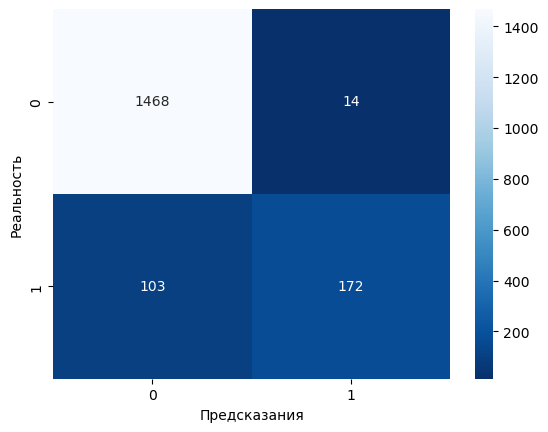

In [63]:
#построение матрицы ошибок
cmc = confusion_matrix(y_test,y_pred)
sns.heatmap(cmc, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальность')
plt.xlabel('Предсказания')
plt.show()

Дополнительно сразу построим график ROC-кривой, используя инструмент `RocCurveDisplay`, передав ему в качестве аргументов метки классов тестовой выборки и метки вероятностей принадлежности к классам, рассчитанные моделью

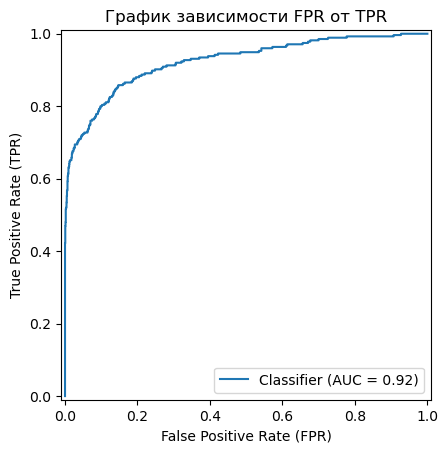

In [64]:
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

**Полученные графики показывают следующее:**
- матрица ошибок показывывает, что модель ошибается менее чем в 10% случаев, перевеса в сторону ошибок одного из классов не наблюдается, в среднем ошибается в предсказании каждого класса на 7-8%
- график ROC-кривой показывает, что площадь под кривой достаточно велика и модель правильно классифицирует 92% случаев, что также отражает высокие результаты работы модели при разных порогах классификации

## Анализ важности признаков и рекомендации

Посмотрим на коэффициенты важности признаков, которые модель рассчитала для каждого входного признака, чтобы понять какие из них оказывают существенное влияние на принятие решений моделью. У нашей лучшей модели CatBoostClassifier() для отображения важности признаков воспользуемся методом `get_feature_importance()`, чтобы получить веса признаков. Создадим датафрейм, где наименованиями столбцов будут служить названия предобработанных данных из шага пайплайна, на котором эти данные кодировались и масштабировались. 

In [65]:
#создаем датафрейм для значений важности и наименований каждого столбца, данные берем из пайплайна с лучшей обученной моделью
feature_importances_boost = pd.DataFrame(
    {
        'Feature': grid_boost.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': round(pd.Series(grid_boost.best_estimator_.named_steps['models'].get_feature_importance()),3)
    })

Визуализируем график важности признаков

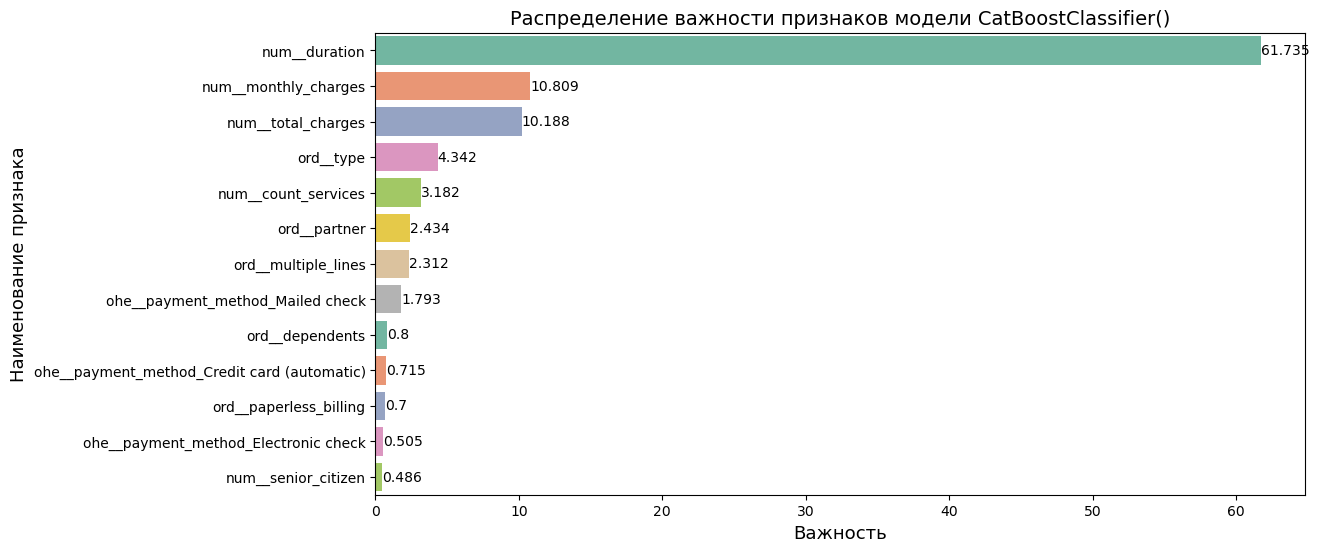

In [66]:
#рисуем график важности признаков
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances_boost.\
                    sort_values(by='Importance', ascending = False), palette = 'Set2', hue = 'Feature')
#указываем значения на каждой оси
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Важность', fontsize = 13)
plt.ylabel('Наименование признака', fontsize = 13)
plt.title('Распределение важности признаков модели CatBoostClassifier()', fontsize = 14)
plt.show()

**Полученный график важности признаков показывает следующее:**
- сильнее всего на принятие решений моделью оказывает признак с длительностью договора `duration`
- на втором месте по важности находятся признаки `monthly_charges` и `total_charges`
- наименее важными признаками являются `senior_citizen`, `paperless_billing` и `payment_method` и `dependents`

Теперь проанализируем к какому классу склоняет модель каждый признак в зависимости от своего значения при помощи SHAP, чтобы составить более направленные рекомендации заказчику. 

Подготоваливаем данные для передачи в TreeExplainer:

In [67]:
#подгатавливаем данные
X_train_transform = pd.DataFrame(
    grid_boost.best_estimator_.named_steps['preprocessor'].transform(X_train),
    columns = grid_boost.best_estimator_.named_steps['preprocessor'].get_feature_names_out()    
) 

X_test_transform = pd.DataFrame(
    grid_boost.best_estimator_.named_steps['preprocessor'].transform(X_test),
    columns = grid_boost.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
)

Считаем значения SHAP. Удобство использования модели CatBoostClassifier() заключается в том, что предобученную модель можно напрямую передавать в TreeExplainer:

In [68]:
explainer = shap.TreeExplainer(grid_boost.best_estimator_.named_steps['models'])

# Получаем SHAP значения
shap_values = explainer.shap_values(X_test_transform)

Строим график пчелиного роя

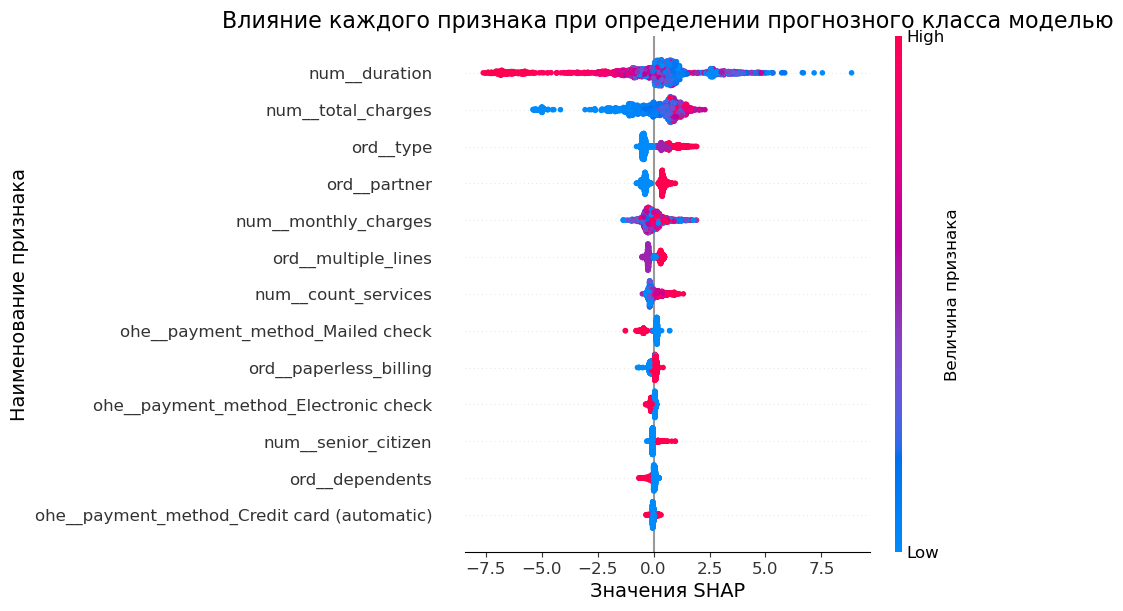

In [69]:
#объявляем график до подписания осей и установки размеров и указываем show=False, 
#чтобы можно дополнительно было настроить график после его создания.
#параметром plot_size расстягиваем значения по ширине, чтобы они были не узкие
shap.summary_plot(shap_values, X_test_transform, show=False, plot_size=[10,6])

#объявляем фигуру и объекты осей
fig, ax = plt.gcf(), plt.gca()

#размер наименования подписи каждого признака
ax.tick_params(labelsize=12)

#подписи осей и наименования графика
ax.set_xlabel("Значения SHAP", fontsize=14)
ax.set_ylabel("Наименование признака", fontsize=14)
ax.set_title('Влияние каждого признака при определении прогнозного класса моделью', fontsize=16)

# Установить размер для величин high и low 
fig.axes[1].tick_params(labelsize=12)
#установить размер подписи цветовой шкалы
fig.axes[1].set_ylabel("Величина признака", fontsize=12)

#отображение конечного графика
plt.show()

**График пчелиного роя показал следующее:**

*Признаки с более существенным влиянием на принятие решений моделью:*
- при увеличении длительности действия договора сильно повышается веростноять отнесения клиента к классу тех, кто продлевает договор
- снижение ежемесячных платежей повышает веростноять отнесения клиента к классу тех, кто продлевает договор
- из-за большого всплеска новых клиентов в конце 2020 года, значения с меньшими общими платежами сильно повышают вероятность отнесения таких клиентов к классу тех, кто продлевает договор.
- при выборе более длинного периода для типа оплаты (один-два года вместо ежемесячных платежей) повышается вероятность отнесения клиента к классу тех, кто расторгает договор

*Признаки с менее существенным влиянием на принятие решений моделью:*
- увеличение количества подключенных интернет-услуг повышает вероятность отнесения моделью клиента к классу тех, кто расторгает договор
- наличие супруги/супруга повышает вероятность отнесения клиента к классу тех, кто расторгает договор
- наличие подключенной услуги разговора по нескольким телефонным линиям одновременно повышает вероятность отнесения клиента к классу тех, кто расторгает договор
- факт того, является ли клиент пенсионером, повышает вероятность отнесения такого клиента к классу тех, кто расторгает договор
- наличие у клиента детей повышает вероятность отнесения клиента к классу тех, кто продлевает договор

***Учитывая полученные графики исследовательского анализа, графики важности признаков и пчелиного роя, рекомендации заказчику могут быть следующими:***
- внедрить разработанную модель машинного обучения с низким процентом ошибок, которая будет классифицировать и помечать тех клиентов, которые могут уйти. В этом случае можно заранее направить клиенту персональную скидку на услуги, промокод, или пересмотреть его тарифный план в сторону большей лояльности по отношению к такому клиенту
- периоды от 400 до 1000 дней в большей степени и от 1000 дней до 1700 дней в меньшей степени самые важные и критичные в плане удержания клиента. Для первого сегмента клиентов  (от 400 до 1000 дней)  можно предлагать чаще промокоды и скидки на услуги связи, для второго сегмента (от 1000 до 1700 дней) внедрить поощрительную систему накопительных баллов для постоянных клиентов (например, периодическое начисление баллов в выбранный временной период, если пользуешься услугами связи 1000 дней и более) с возможностью использования этих баллов для оплаты услуг по договору. В этом случае и у наиболее критичного сегмента от 400 до 1000 дней помимо дополнительных скидок на услуги и промокодов будет стимул продления договора на более длительный срок, чтобы получать дополнительные баллы
- можно внедрить обратную связь и опросы для наиболее уязвимых клиентов с длительностью договора от 400 до 1000 дней, чтобы быстрее реагировать на проблемы
- так как клиенты с высоким ежемесячным платежом уходят чаще, чем с низким, то можно им предложить разбивать оплату на части
- вероятность ухода для клиентов, которые потратили больше 5000, сильно снижается, можно еще сильней закрепить  их лояльность, предложив им индивидуальные постоянные скидки, например, в 10% 
- учитывая повышение вероятности уходя для клиентов, имеющих супруга/супругу, возможно:
  - предлагать скидку при совместном подключении и заключении договора на обслуживание
  - разработать специальные семейные тарифы, выгодные для подключения сразу группы пользователей (аналог - "Группа Семья" в МТС, пользуюсь сам, отлично работает для привлечения сразу нескольких клиентов и последующего их удержания на долгий период за счет более выгодного общего тарифа)
- так как с увеличением подключенных интернет-услуг увеличивается вероятность ухода клиентов, то можно попробовать разработать тарифы, включающие сразу комплект услуг или скидку при подключении сразу комплекта нескольких услуг.
- так как в сегменте с 0 подключенных интернет услуг доля ухода таких клиентов минимальна, то не нужно тревожить навязыванием дополнительных опций таких клиентов. 
- так как услуга разговора по нескольким телефонным линиям повышает вероятность ухода клиента, то необходимо пересмотреть условия по этой услуге
- учитывая увеличение вероятности ухода, если клиент является пенсионером, то  можно разработать специальный тариф для пенсионеров, включающий более лояльные условия или скидку на услуги связи для менее защищенного слоя населения, или упростить условия пользования, так как возрастные люди менее склонны к тому, чтобы разбираться в большом объеме информации и услуг.

## Итоговые выводы

**В нашем исследовании были проделаны следующие этапы работ и получены следующие результаты:**

**На этапе предобработки данных были получены следующие результаты:**
- в наименованиях столбцов добавлены нижние подчеркивания. Наименования столбцов приведены к змеиному регистру, проведена проверка на лишние знаки и пробелы.
- явных пропущенных значений в датафреймах не обнаружено
- проанализированы описательные статистики всех типов столбцов
- в столбце `end_date` у 5942 объектов, которые имеют действующий договор, значение `No` заменено на дату получения среза данных `2020-02-01`
- в столбце `total_charges` были удалены 11 объектов, у которых в этом столбце были неявные пропуски из-за того, что они в дату получения среза данных заключили договор и оплата еще не прошла
- тип данных столбца `end_date` изменен на `datetime64[ns]`
- тип данных столбца `total_charges` изменен на `float`
- все датафреймы последовательно соединены друг с другом при помощи `merge` и `join` по столбцам-индексам.
- при объединении в датафрейме `df_internet` не нашлось 5 строк с необходимыми индексами клиентов, а в `df_phone` не нашлось 9 соответствующих индексов клиентов, поэтому эти строки при объединении в общий датафрейм не попали.
- образовавшиеся пропущенные значения в столбцах с информацией об интернет-услугах и телефонии были заменены на значения-заглушки `unknown`.
- удалено 4 явных дубликаты в объединенном датафрейме
- проверено наличие неявных дубликатов
- были добавлены новые столбцы в объединенный датафрейм:
  -  целевой признак `terminated`. Для всех клиентов с датой `2020-02-01` указан класс 0 (договор активный), а всем остальным клиентам просвоено значение 1 (договор завершен). Наблюдается дисбаланс классов. Клиентов, расторгнувших договор, 18.5% от общего числа.
  - входной признак `duration`, отображающий длительность договора в днях
  - входной признак `count_services`, отображающий кол-во подключенных интернет-услуг. Для клиентов, у которых нет интернета, проставлено значение-заглушка `-1`
  - входной бинарный признак `changed_service`, показывающий менял или подключал какие-либо услуги клиент или нет, со значениями:
    - `Yes` - если менял тариф/подключал услуги
    - `No` - если услуги не добавлял/тариф не менял

**На этапе исследовательского анализа были получены следующие результаты:**

***Полученные статистики показали следующее:***
- из даты заключения и окончания договоров видно, что предоставлены данные за период с октября 2013 года по февраль 2020
- медианное значение среднемесячных платежей за тариф и услуги составляет 70.35, а общих платежей за все время - 1345.275
- пенсионеров в наших данных около 19.4% от общего числа
- клиентов, прекративших договор, окло 18.5% от общего числа, явных дисбаланс классов, нужно будет применить стратификацию и балансировку весов в моделях
- медианное значение длительности договора составляет 2 года у данного оператора
- медианное значение подключенных интернет-услуг у пользователей - 2
- клиенты чаще меняют тариф или подключают услуги, чем ничего не меняют за все время действия договора
- если рассматривать каждую интернет-услугу, то люди чаще не пользуются ими, чем подключают
- чаще всего люди выбирают ежемесячный способ оплаты
- наибольшая часть клиентов не имеет детей и не женаты
- мужчин и женщин практически поровну среди клиентов

***Графики количественных признаков показали следующее:***
- всплески новых пользователей были в начале 2014 года и в конце 2020 года. График показывает, что до 2016 года доля ушедших от общего количества клиентов была равномерна, но после 2016 до 2020 года кол-во ушедших пользователей от общего количества заключивших договора постоянно уменьшается, при это кол-во пользователей, вновь заключивших договор, с 2016 года только растет.
- клиентов, прекративших договор, малая часть от общего кол-ва, как мы видели по статистикам, около 18.5%
- около 1000 активных клиентов предпочитают небольшие ежемесячные платежи– в области 20. У активных клиентов выделяются три сегмента по ежемесячным платежам – в областях 20, 50 и 75. У ушедших клиентов сглаживающая кривая достигает своего пика в области 90. Медианное значение ежемесячных платежей для активных клиентов – 70, а для ушедших – в области 85
- больше всего активных клиентов с общей суммой платежей до 2000, это может быть также связно с тем, что с середины 2020 года и до конца года был очень большой всплеск новых пользователей.
- медианное значение общих платежей для ушедших пользователей составляет 2100, а для действующих клиентов в районе 1200.
- свыше 5000 суммы общих платежей подавляющее большинство клиентов с действующим договором. Следовательно, чем больше и дольше человек является клиентом, тем меньше вероятность того, что он расторгнет договор
- доля ушедших пенсионеров от общего количества пенсионеров больше, чем доля ушедших клиентов среди всех остальных клиентов 
- на графике длительности действия договора виден скачек в области 150 дней, связанный с тем, что в конце 2020 года был всплеск новых пользователей. Также наблюдается пик в области более 2000 дней. По графику оставшихся-действующих клиентов также видно, доля ушедших пользователей выходит на плато области 1000 дней, где доля ушедших клиентов от общего количества максимальная, и после этого числа количество ушедших пользователей становится меньше, а после 1700 дней количество ушедших пользователей становится минимально, что еще раз подтверждает зависимость: чем длительнее становится договор, тем меньше становится вероятность того, что клиент его расторгнет
- по графику количества услуг видно, что самая большая группа – это клиенты, не пользующиеся интернетом в принципе. Для пользователей с интернетом видно, что чаще других у пользователей подключено 3 услуги. 

*Дополнительный график для групп с количеством подключенных интернет-услуг показал следующее:*
- наименьшая доля клиентов, расторгнувших договор, находится в группе с 0 подключенных услуг
- доля клиентов, расторгнувших договор, увеличивается в каждой группе по мере увеличения кол-ва подключенных услуг и показывает наибольшее значение в группе с 4 подключенными услугами, после чего немного уменьшается.
- доля ушедших клиентов, не имеющих интернет, от общего количества клиентов в  группе достаточна низкая и сопоставима с группой клиентов с 1 подключенной услугой 

*Дополнительные графики для непрерывных признаков покащали следующее:*
- при увеличении ежемесячной платы доля ушедших клиентов увеличивается, особенно это заметно после 80
- свыше 6000 общих платежей доля ушедших клиентов сильно снижается
- при нормализации данных по плотности видно, что доля ушедших клиентов с общими тратами от 2000 до 4000 сильно выше, чем оставшихся клиентов
- на графике длительности договора сглаживающие пересекаются в районах 400 и 1700 дней, значит, в период с 400 по 1700 день наиболее важно удержать клиента и не допустить его ухода
- до 1000 дней длительности действия договора вероятность расторжения договора возрастает, после 1000 дней вероятность этого события снижается

***Полученные графики для категориальных признаков показали следующее:***
- около половины всех клиентов пользуются ежемесячным типом платежа, остальные типы платежей распределены практически поровну между собой
- доля ушедших клиентов от общего количества минимальна в группе с ежемесячным типом платежа - около 12%, для остальных типов платежей доля ушедших составляет примерно 27%
- наибольшая часть клиентов (3446) предпочитает электронный расчетный лист. Доля ушедших немного выше в группе с электронным расчетным листом
- больше всего клиенты выбирают тип платежа - электронный чек. Доля ушедших от общего количества в группе меньше всего в группе с типом платежа чека по эл. почте, в остальных группах доли ушедших примерно одинаковые.
- в признаке пол клиента общее распределение и распределение в зависимости от состояния договора примерно одинаковое, такой признак скорее всего не будет полезен для моделей, посмотрим корреляцию с целевым признаком и примем решение удалять или оставить этот признак
- клиентов в браке немного меньше, чем свободных. Доля ушедших клиентов больше более чем в два раза в группе клиентов, состоящих в браке.
- клиентов без детей примерно в два раза больше, чем с детьми. Доли ушедших клиентов в обоих группах составляют примерно 20%
- самая большая группа клиентов предпочитают Fiber optic (3095). Доля клиентов без интернета меньше всех (1517). При сравнении групп договор расторгнут/действующий видно, что доля расторгнувших договор меньше всех в группе клиентов, не имеющих интернет, около 11%, а больше всего в группе с оптическим волокном – около 24%
- во всех признаках с разными интернет-услугами доля ушедших клиентов выше в группах клиентов, где услуга подключена.
- клиенты с подключенной услугой разговора по нескольким телефонным линиям одновременно также расторгают договора намного чаще (порядка 30%), чем клиенты, у которых такая опция не подключена (порядка 10%).
- новый признак `changed_service` показывает, что клиентов, которые меняли тариф или добавляли услуги, больше чем в два раза больше, чем клиентов, которые ничего не меняли в своем тарифе. Распределение долей ушедших клиентов от общего количества в группах примерно одинаковое.

**На этапе корреляционного анализа полученная матрица со всеми входными признаками показала следующее:**
- присутствует мультиколлинеарность между всеми входными признаками с интернет услугами. Так как мы создали новый признак с количество услуг `count_services`, который коррелирует с целевым признаком `terminated`(коэффициент корреляции 0.27), то уберем мультиколлинеарность и удалим все признаки с интернет-услугами: `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies`, коэффициент корреляции у которых с целевыми признаком не выше 0.09
- целевой признак `terminated` был создан на основе столбца `end_date`, поэтому теперь у них коэффициент корреляции между собой 1, из-за этого этот признак может сильно взять на себя роль самого важного признака и тем самым исказить результаты работы моделей. Также удалим этот признак.
- столец `begin_date` также имеет мультиколлинеарность с другим новым признаком `duration`. Столбец с временным типом данных напрямую в модель передать нельзя. До этого мы столбец с временным типом данных при работе модели использовали только в теме про временные ряды в задаче регрессии, когда из него создавали признаки месяц, день, день недели, разности ряда, когда исследовали тренды и сезонность. В текущей задаче думаю нет смысла переводить в целочисленный тип этот столбец или на его основе получать дни или месяцы, поэтому удалим именно этот признак и оставим признак `duration`.
- признак `gender` подтвердил результаты исследовательского анализа - он не имеет корреляции с целевым признаком, удалим его
- признак `internet_service` имеет мультиколлинеарность с другим входны признаком - `monthly_charges`. Но так как `monthly_charges` имеет коэффициент корреляции с целевым признаком 0.23, а `internet_service` 0.056, то удалим именно признак `internet_service` и устраним мультиколлинеарность
- новые признаки `count_services` и `duration` показали корреляцию с целевым признаком выше, чем у остальных признаков, будем использовать их в обучении
- новый признак `changed_service` не имеет корреляции с целевым признаком, поэтому его при обучении моделей использовать не будем

***После удаления признаков `begin_date`, `end_date`, `gender`, `changed_service`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_t_v`,`streaming_movies` из датасета матрица корреляции была построена повторно и показала следующее:***

- мультиколлинеарность между входными признаками устранена
- наибольшая корреляция с целевым признаком у признаков `duration`(0.37) и `count_services`(0.27)
- наблюдается высокая корреляция между входными признаками `duration` и `total_charges` - 0.85 и между `count_services` и `monthly_charges` - 0.81

**На этапе обучения моделей были проделаны следующие шаги и получены следующие результаты:**

- на основании исследовательского и корреляционного анализа из датасета были отобраны признаки для обучения моделей, данные были разбиты на тренировочную и тестовую выборки
- данные были подготовлены при помощи ColumnTransformer(), создан пайплайн `data_preprocessor` для подготовки данных, включающий масштабирование данных и кодирование с обработкой пропусков
- обучение моделей с автоматизированным поиском гиперпараметров при помощи GridSearchCV() и RandomizedSearchCV() было разделено на три этапа:
  - на ***первом этапе*** при обучении моделей SVC() и LogisticRegression() ***лучшей моделью оказалась модель SVC(C=3,kernel='rbf'), ROC-AUC при кросс-валидации составила 0.744***
  - на ***втором этапе*** при обучении моделей DecisionTreeClassifier() и KNeighborsClassifier() были получены следующие лучшие результаты для каждого типа моделей:
    - ***лучшая модель `DecisionTreeClassifier(max_depth=6, max_features=5, min_samples_leaf=2, min_samples_split=6, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.792`***
    - ***лучшая модель `KNeighborsClassifier(n_neighbors=66, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.803.`*** Увеличения метрики у этой модели удалось достичь после увеличения диапазона значений гиперпараметра `n_neighbors`
  - ***лучшей моделью третьего этапа обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913`***, при этом таблица с результатами обучения третьего этапа показала следующее:
    - в десятку лучших моделей входят только модели CatBoostClassifier(), ни одна из моделей LGBMClassifier() не оказалась в числе лучших
    - увеличенный диапазон `iterations` до 1400 со стандартного 1000 позволил улучшить итоговую метрику
    - оптимальный шаг обучения `learning_rate` для всех лучших 10 моделей оказался 0.1
    - значение параметра `depth` для лучших моделей оказалось не крайним значением из указанного диапазона для обучения, поэтому увеличение значений для этого гиперпараметра не производилось 

**При сравнении всех обученных моделей на всех трех этапах общая таблица с результатами показала следующее:**
- хоть время обучения модели CatBoostClassifier() намного дольше по сравнению с остальными моделями, зато прогнозное время такое же, как у модели KNeighborsClassifier() и намного меньше, чем у модели SVC()
- минимальное прогнозное время у модели DecisionTreeClassifier()	
- все модели показали итоговую метрику сильно меньше, чем у модели бустинга CatBoostClassifier()

***Лучшей моделью среди всех этапов обучения оказалась модель `CatBoostClassifier(depth=3, iterations=1400, learning_rate=0.1, StandardScaler()), метрика ROC-AUC при кросс-валидации составила 0.913, `***

**На этапе тестирования и проверки на адекватность:**
- лучшая модель CatBoostClassifier() показала итоговые метрики ROC-AUC = 0.923 и  Accuracy = 0.933
- также прошла проверку на адекватность, показав метрику выше константной модели DummyClassifier()

**При анализе прогнозных значений полученные графики показали следующее:**
- матрица ошибок показывывает, что модель ошибается менее чем в 10% случаев, перевеса в сторону ошибок одного из классов не наблюдается, в среднем ошибается в предсказании каждого класса на 7-8%
- график ROC-кривой показывает, что площадь под кривой достаточно велика и модель правильно классифицирует 92% случаев, что также отражает высокие результаты работы модели при разных порогах классификации

**Полученный график важности признаков показал следующее:**
- сильнее всего на принятие решений моделью оказывает признак с длительностью договора `duration`
- на втором месте по важности находятся признаки `monthly_charges` и `total_charges`
- наименее важными признаками являются `senior_citizen`, `paperless_billing` и `payment_method` и `dependents`

**График пчелиного роя показал следующее:**

*Признаки с более существенным влиянием на принятие решений моделью:*
- при увеличении длительности действия договора сильно повышается веростноять отнесения клиента к классу тех, кто продлевает договор
- снижение ежемесячных платежей повышает веростноять отнесения клиента к классу тех, кто продлевает договор
- из-за большого всплеска новых клиентов в конце 2020 года, значения с меньшими общими платежами сильно повышают вероятность отнесения таких клиентов к классу тех, кто продлевает договор.
- при выборе более длинного периода для типа оплаты (один-два года вместо ежемесячных платежей) повышается вероятность отнесения клиента к классу тех, кто расторгает договор

*Признаки с менее существенным влиянием на принятие решений моделью:*
- увеличение количества подключенных интернет-услуг повышает вероятность отнесения моделью клиента к классу тех, кто расторгает договор
- наличие супруги/супруга повышает вероятность отнесения клиента к классу тех, кто расторгает договор
- наличие подключенной услуги разговора по нескольким телефонным линиям одновременно повышает вероятность отнесения клиента к классу тех, кто расторгает договор
- факт того, является ли клиент пенсионером, повышает вероятность отнесения такого клиента к классу тех, кто расторгает договор
- наличие у клиента детей повышает вероятность отнесения клиента к классу тех, кто продлевает договор

***Учитывая полученные графики исследовательского анализа, графики важности признаков и пчелиного роя, рекомендации заказчику могут быть следующими:***
- внедрить разработанную модель машинного обучения с низким процентом ошибок, которая будет классифицировать и помечать тех клиентов, которые могут уйти. В этом случае можно заранее направить клиенту персональную скидку на услуги, промокод, или пересмотреть его тарифный план в сторону большей лояльности по отношению к такому клиенту
- периоды от 400 до 1000 дней в большей степени и от 1000 дней до 1700 дней в меньшей степени самые важные и критичные в плане удержания клиента. Для первого сегмента клиентов  (от 400 до 1000 дней)  можно предлагать чаще промокоды и скидки на услуги связи, для второго сегмента (от 1000 до 1700 дней) внедрить поощрительную систему накопительных баллов для постоянных клиентов (например, периодическое начисление баллов в выбранный временной период, если пользуешься услугами связи 1000 дней и более) с возможностью использования этих баллов для оплаты услуг по договору. В этом случае и у наиболее критичного сегмента от 400 до 1000 дней помимо дополнительных скидок на услуги и промокодов будет стимул продления договора на более длительный срок, чтобы получать дополнительные баллы
- можно внедрить обратную связь и опросы для наиболее уязвимых клиентов с длительностью договора от 400 до 1000 дней, чтобы быстрее реагировать на проблемы
- так как клиенты с высоким ежемесячным платежом уходят чаще, чем с низким, то можно им предложить разбивать оплату на части
- вероятность ухода для клиентов, которые потратили больше 5000, сильно снижается, можно еще сильней закрепить  их лояльность, предложив им индивидуальные постоянные скидки, например, в 10% 
- учитывая повышение вероятности уходя для клиентов, имеющих супруга/супругу, возможно:
  - предлагать скидку при совместном подключении и заключении договора на обслуживание
  - разработать специальные семейные тарифы, выгодные для подключения сразу группы пользователей (аналог - "Группа Семья" в МТС, пользуюсь сам, отлично работает для привлечения сразу нескольких клиентов и последующего их удержания на долгий период за счет более выгодного общего тарифа)
- так как с увеличением подключенных интернет-услуг увеличивается вероятность ухода клиентов, то можно попробовать разработать тарифы, включающие сразу комплект услуг или скидку при подключении сразу комплекта нескольких услуг.
- так как в сегменте с 0 подключенных интернет услуг доля ухода таких клиентов минимальна, то не нужно тревожить навязыванием дополнительных опций таких клиентов. 
- так как услуга разговора по нескольким телефонным линиям повышает вероятность ухода клиента, то необходимо пересмотреть условия по этой услуге
- учитывая увеличение вероятности ухода, если клиент является пенсионером, то  можно разработать специальный тариф для пенсионеров, включающий более лояльные условия или скидку на услуги связи для менее защищенного слоя населения, или упростить условия пользования, так как возрастные люди менее склонны к тому, чтобы разбираться в большом объеме информации и услуг.